In [1]:
import numpy as np
import pandas as pd
import os
import re
import seaborn as sns
from sklearn.base import clone, BaseEstimator, RegressorMixin
from sklearn.metrics import cohen_kappa_score, accuracy_score, mean_squared_error
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.decomposition import PCA
from sklearn.datasets import make_classification
from scipy.optimize import minimize
from concurrent.futures import ThreadPoolExecutor
from tqdm import tqdm
import missingno as msno

from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from keras.models import Model
from keras.layers import Input, Dense
from keras.optimizers import Adam
import torch
import torch.nn as nn
import torch.optim as optim

from colorama import Fore, Style
from IPython.display import clear_output
import warnings
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from sklearn.ensemble import VotingRegressor, RandomForestRegressor, GradientBoostingRegressor
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.pipeline import Pipeline
warnings.filterwarnings('ignore')
pd.options.display.max_columns = None

from bayes_opt import BayesianOptimization
from sklearn.metrics import mean_squared_error

In [2]:
def process_file(filename, dirname):
    df = pd.read_parquet(os.path.join(dirname, filename, 'part-0.parquet'))
    df.drop('step', axis=1, inplace=True)
    return df.describe().values.reshape(-1), filename.split('=')[1]

def load_time_series(dirname) -> pd.DataFrame:
    ids = os.listdir(dirname)
    
    with ThreadPoolExecutor() as executor:
        results = list(tqdm(executor.map(lambda fname: process_file(fname, dirname), ids), total=len(ids)))
    
    stats, indexes = zip(*results)
    
    df = pd.DataFrame(stats, columns=[f"stat_{i}" for i in range(len(stats[0]))])
    df['id'] = indexes
    return df

LOAD DATA

In [3]:
train = pd.read_csv('/kaggle/input/child-mind-institute-problematic-internet-use/train.csv')
test = pd.read_csv('/kaggle/input/child-mind-institute-problematic-internet-use/test.csv')
sample = pd.read_csv('/kaggle/input/child-mind-institute-problematic-internet-use/sample_submission.csv')
dict = pd.read_csv('../input/child-mind-institute-problematic-internet-use/data_dictionary.csv')

train_ts = load_time_series("/kaggle/input/child-mind-institute-problematic-internet-use/series_train.parquet")
test_ts = load_time_series("/kaggle/input/child-mind-institute-problematic-internet-use/series_test.parquet")

100%|██████████| 2/2 [00:00<00:00, 11.67it/s]


PREPROCESS CSV

In [4]:
dict

,Instrument,Field,Description,Type,Values,Value Labels
0,Identifier,id,Participant's ID,str,NaN,NaN
1,Demographics,Basic_Demos-Enroll_Season,Season of enrollment,str,"Spring, Summer, Fall, Winter",NaN
2,Demographics,Basic_Demos-Age,Age of participant,float,NaN,NaN
3,Demographics,Basic_Demos-Sex,Sex of participant,categorical int,"0,1","0=Male, 1=Female"
4,Children's Global Assessment Scale,CGAS-Season,Season of participation,str,"Spring, Summer, Fall, Winter",NaN
...,...,...,...,...,...,...
76,Sleep Disturbance Scale,SDS-Season,Season of participation,str,"Spring, Summer, Fall, Winter",NaN
77,Sleep Disturbance Scale,SDS-SDS_Total_Raw,Total Raw Score,int,NaN,NaN
78,Sleep Disturbance Scale,SDS-SDS_Total_T,Total T-Score,int,NaN,NaN
79,Internet Use,PreInt_EduHx-Season,Season of participation,str,"Spring, Summer, Fall, Winter",NaN


In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3960 entries, 0 to 3959
Data columns (total 82 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   id                                      3960 non-null   object 
 1   Basic_Demos-Enroll_Season               3960 non-null   object 
 2   Basic_Demos-Age                         3960 non-null   int64  
 3   Basic_Demos-Sex                         3960 non-null   int64  
 4   CGAS-Season                             2555 non-null   object 
 5   CGAS-CGAS_Score                         2421 non-null   float64
 6   Physical-Season                         3310 non-null   object 
 7   Physical-BMI                            3022 non-null   float64
 8   Physical-Height                         3027 non-null   float64
 9   Physical-Weight                         3076 non-null   float64
 10  Physical-Waist_Circumference            898 non-null    floa

In [6]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 59 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   id                                      20 non-null     object 
 1   Basic_Demos-Enroll_Season               20 non-null     object 
 2   Basic_Demos-Age                         20 non-null     int64  
 3   Basic_Demos-Sex                         20 non-null     int64  
 4   CGAS-Season                             10 non-null     object 
 5   CGAS-CGAS_Score                         8 non-null      float64
 6   Physical-Season                         14 non-null     object 
 7   Physical-BMI                            13 non-null     float64
 8   Physical-Height                         13 non-null     float64
 9   Physical-Weight                         13 non-null     float64
 10  Physical-Waist_Circumference            5 non-null      float64


<Axes: >

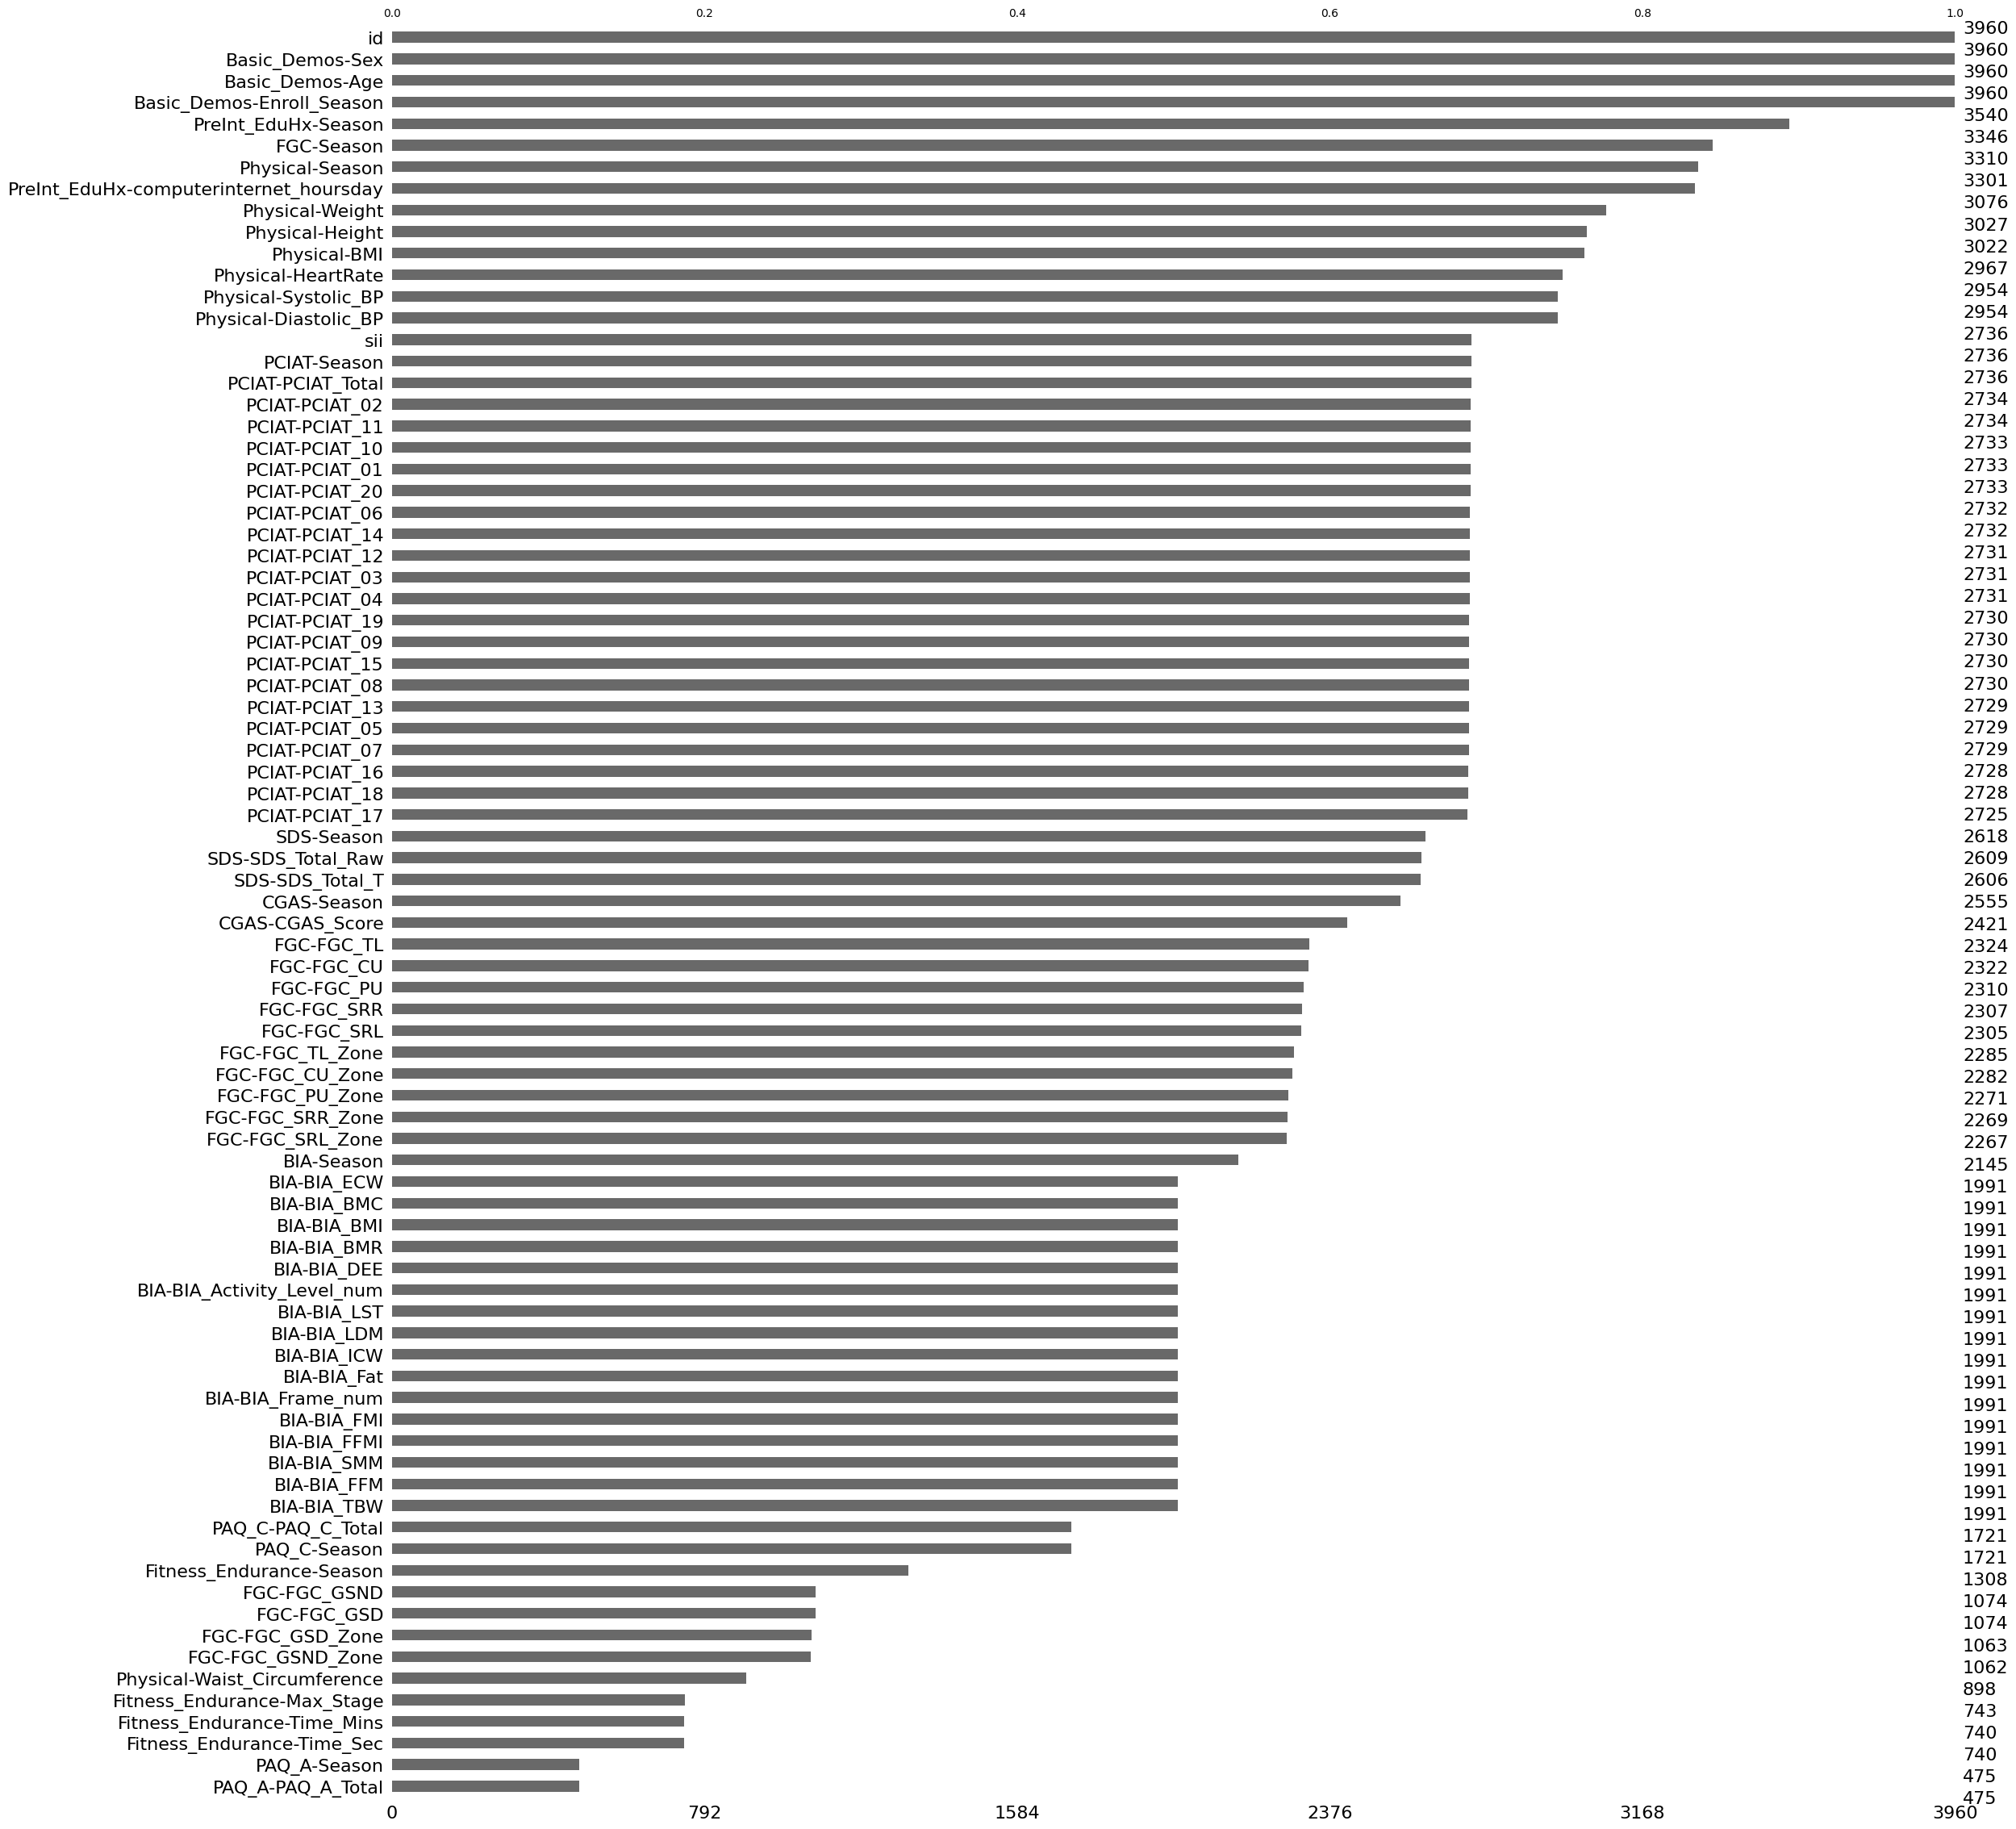

In [7]:
msno.bar(train.iloc[:, :train.shape[1]], sort='ascending')

<Axes: >

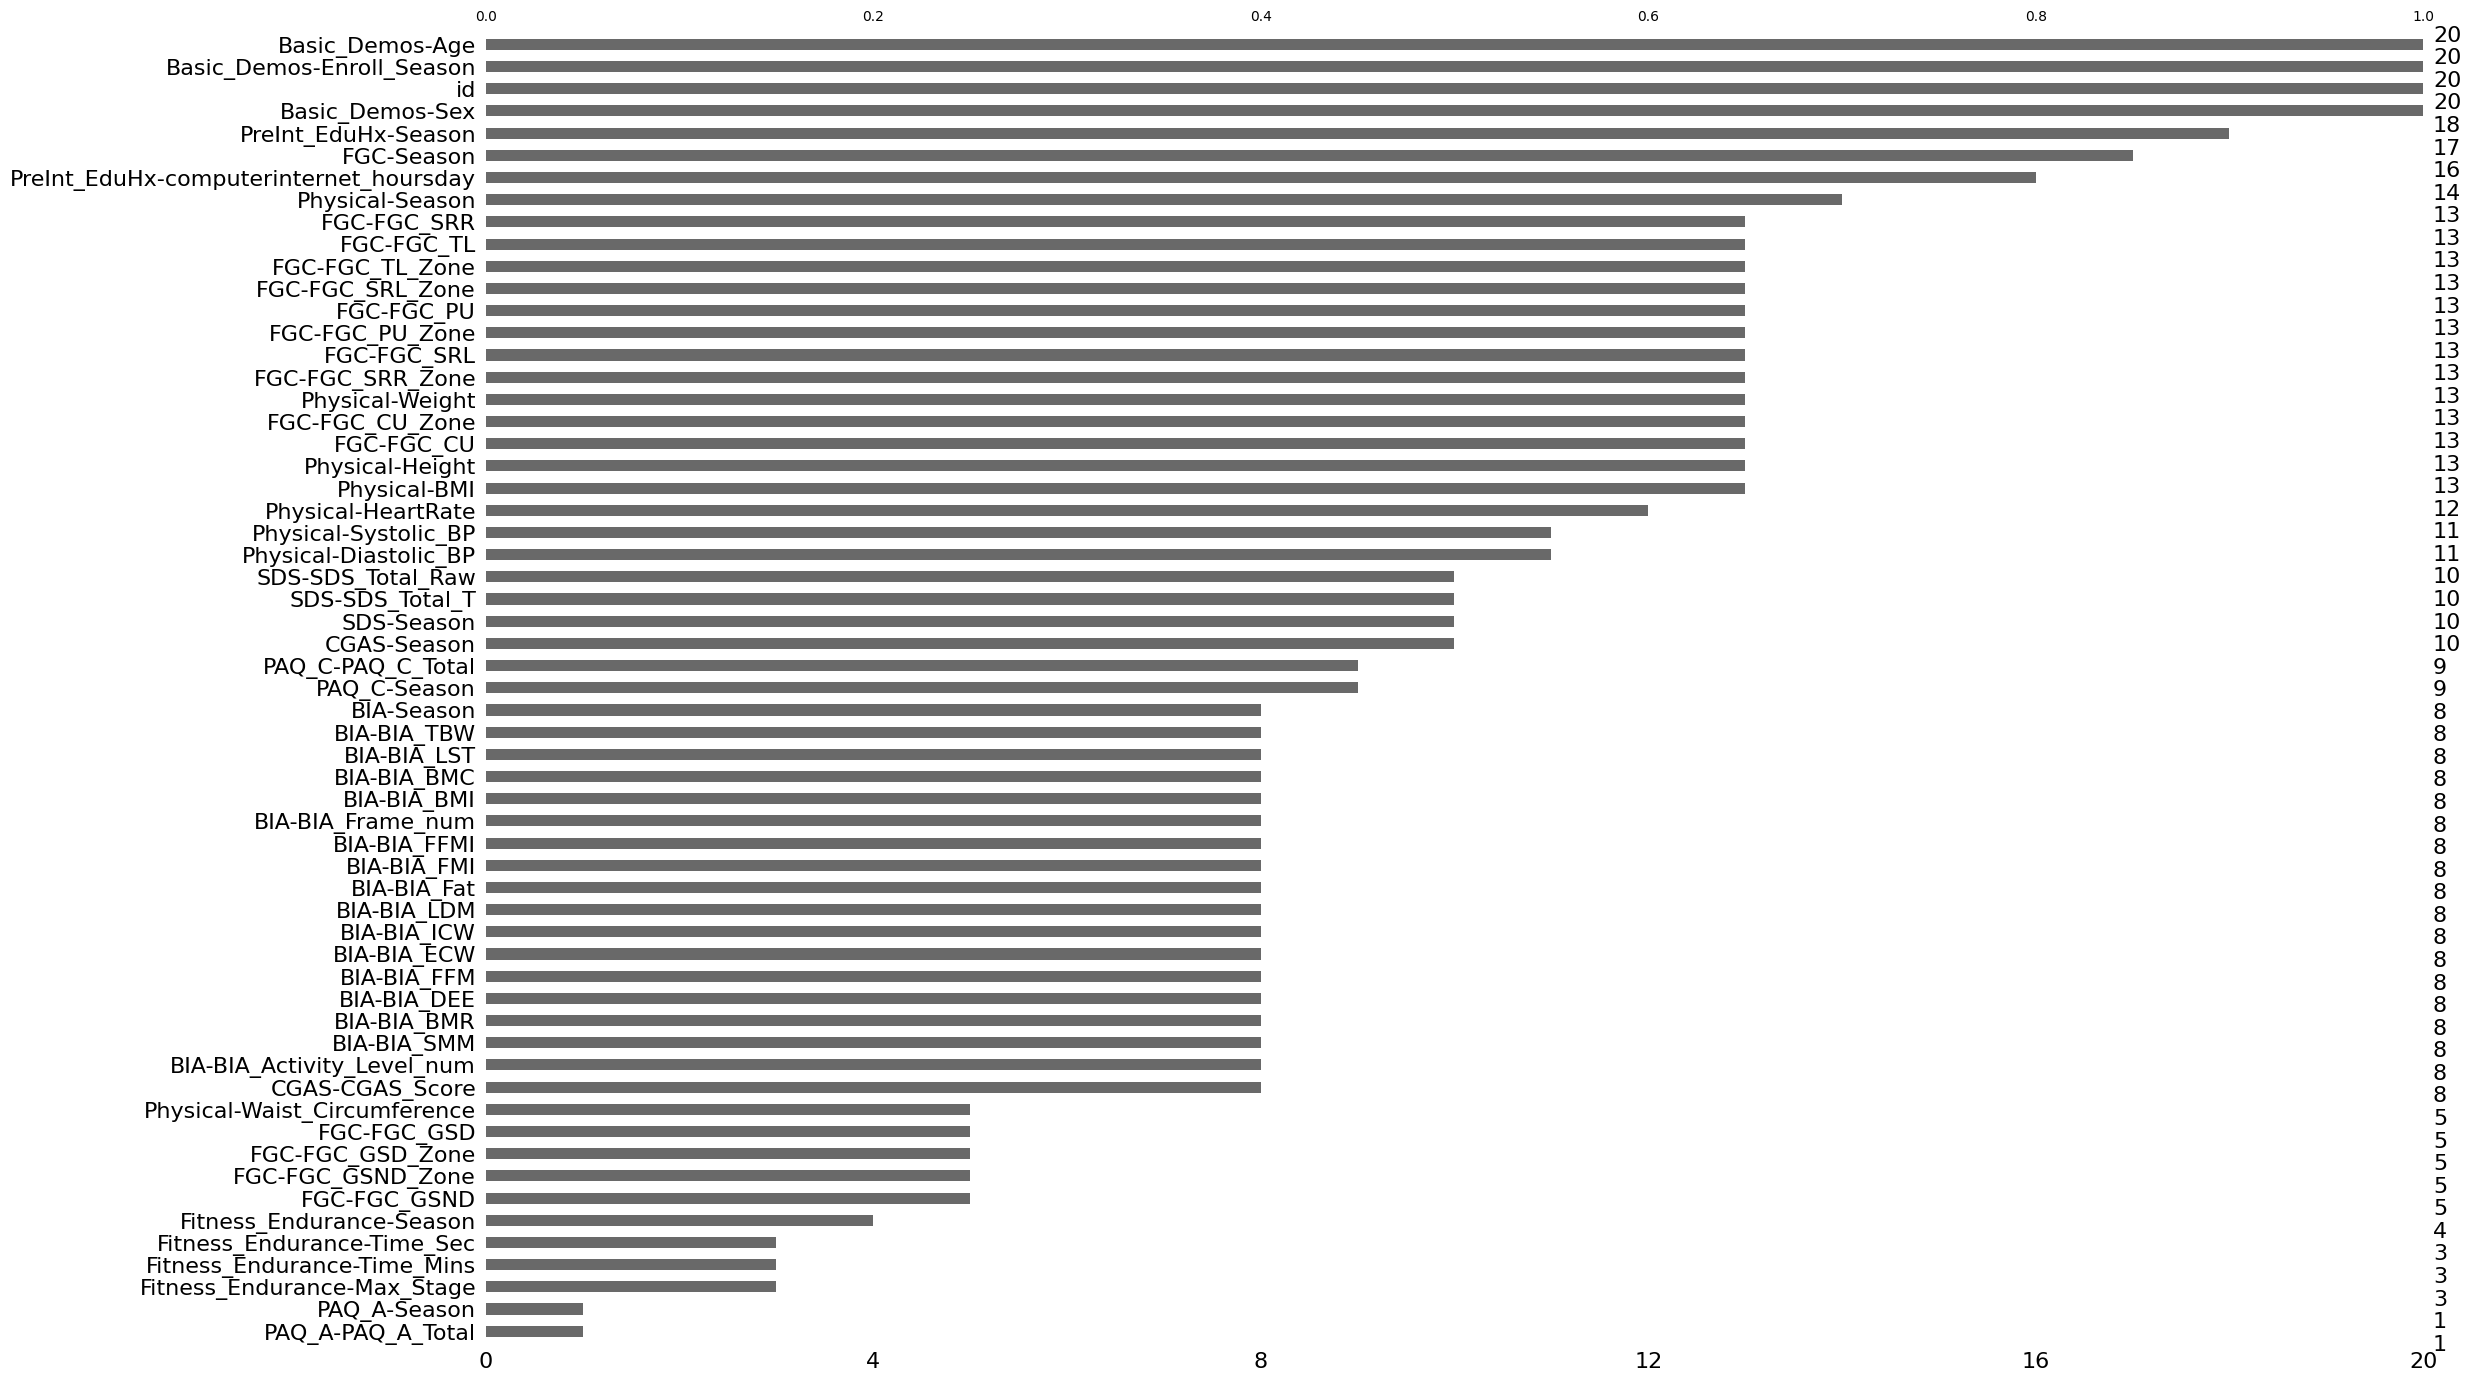

In [8]:
msno.bar(test.iloc[:, :test.shape[1]], sort='ascending')

In [9]:
column_not_in_test = set(train.columns) - set(test.columns)
column_not_in_test

{'PCIAT-PCIAT_01',
 'PCIAT-PCIAT_02',
 'PCIAT-PCIAT_03',
 'PCIAT-PCIAT_04',
 'PCIAT-PCIAT_05',
 'PCIAT-PCIAT_06',
 'PCIAT-PCIAT_07',
 'PCIAT-PCIAT_08',
 'PCIAT-PCIAT_09',
 'PCIAT-PCIAT_10',
 'PCIAT-PCIAT_11',
 'PCIAT-PCIAT_12',
 'PCIAT-PCIAT_13',
 'PCIAT-PCIAT_14',
 'PCIAT-PCIAT_15',
 'PCIAT-PCIAT_16',
 'PCIAT-PCIAT_17',
 'PCIAT-PCIAT_18',
 'PCIAT-PCIAT_19',
 'PCIAT-PCIAT_20',
 'PCIAT-PCIAT_Total',
 'PCIAT-Season',
 'sii'}

In [10]:
feature_cols = train.columns.intersection(test.columns)
train_df = train[feature_cols]
train_df['sii'] = train['sii']
train = train_df
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3960 entries, 0 to 3959
Data columns (total 60 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   id                                      3960 non-null   object 
 1   Basic_Demos-Enroll_Season               3960 non-null   object 
 2   Basic_Demos-Age                         3960 non-null   int64  
 3   Basic_Demos-Sex                         3960 non-null   int64  
 4   CGAS-Season                             2555 non-null   object 
 5   CGAS-CGAS_Score                         2421 non-null   float64
 6   Physical-Season                         3310 non-null   object 
 7   Physical-BMI                            3022 non-null   float64
 8   Physical-Height                         3027 non-null   float64
 9   Physical-Weight                         3076 non-null   float64
 10  Physical-Waist_Circumference            898 non-null    floa

In [11]:
columns_in_train = pd.DataFrame({'Field': train.columns})

# Explain
train_dict= pd.merge(columns_in_train, dict, on='Field', how='left')
train_dict

,Field,Instrument,Description,Type,Values,Value Labels
0,id,Identifier,Participant's ID,str,NaN,NaN
1,Basic_Demos-Enroll_Season,Demographics,Season of enrollment,str,"Spring, Summer, Fall, Winter",NaN
2,Basic_Demos-Age,Demographics,Age of participant,float,NaN,NaN
3,Basic_Demos-Sex,Demographics,Sex of participant,categorical int,"0,1","0=Male, 1=Female"
4,CGAS-Season,Children's Global Assessment Scale,Season of participation,str,"Spring, Summer, Fall, Winter",NaN
5,CGAS-CGAS_Score,Children's Global Assessment Scale,Children's Global Assessment Scale Score,int,NaN,NaN
6,Physical-Season,Physical Measures,Season of participation,str,"Spring, Summer, Fall, Winter",NaN
7,Physical-BMI,Physical Measures,Body Mass Index (kg/m^2),float,NaN,NaN
8,Physical-Height,Physical Measures,Height (in),float,NaN,NaN
9,Physical-Weight,Physical Measures,Weight (lbs),float,NaN,NaN


In [12]:
train_no_id = train.drop(columns='id')

string_columns = train_no_id.select_dtypes(include=['object']).columns.tolist()
string_columns

['Basic_Demos-Enroll_Season',
 'CGAS-Season',
 'Physical-Season',
 'Fitness_Endurance-Season',
 'FGC-Season',
 'BIA-Season',
 'PAQ_A-Season',
 'PAQ_C-Season',
 'SDS-Season',
 'PreInt_EduHx-Season']

In [13]:
# Season encode - vì tất cả các cột str đều là string
season_encode = {
    'Spring': 1,
    'Summer': 2,
    'Fall': 3,
    'Winter': 4,
    np.nan: 0
}

# Áp dụng mapping cho tất cả các cột kiểu string
train_no_id[string_columns] = train_no_id[string_columns].apply(lambda col: col.map(season_encode))
train_no_id

,Basic_Demos-Enroll_Season,Basic_Demos-Age,Basic_Demos-Sex,CGAS-Season,CGAS-CGAS_Score,Physical-Season,Physical-BMI,Physical-Height,Physical-Weight,Physical-Waist_Circumference,Physical-Diastolic_BP,Physical-HeartRate,Physical-Systolic_BP,Fitness_Endurance-Season,Fitness_Endurance-Max_Stage,Fitness_Endurance-Time_Mins,Fitness_Endurance-Time_Sec,FGC-Season,FGC-FGC_CU,FGC-FGC_CU_Zone,FGC-FGC_GSND,FGC-FGC_GSND_Zone,FGC-FGC_GSD,FGC-FGC_GSD_Zone,FGC-FGC_PU,FGC-FGC_PU_Zone,FGC-FGC_SRL,FGC-FGC_SRL_Zone,FGC-FGC_SRR,FGC-FGC_SRR_Zone,FGC-FGC_TL,FGC-FGC_TL_Zone,BIA-Season,BIA-BIA_Activity_Level_num,BIA-BIA_BMC,BIA-BIA_BMI,BIA-BIA_BMR,BIA-BIA_DEE,BIA-BIA_ECW,BIA-BIA_FFM,BIA-BIA_FFMI,BIA-BIA_FMI,BIA-BIA_Fat,BIA-BIA_Frame_num,BIA-BIA_ICW,BIA-BIA_LDM,BIA-BIA_LST,BIA-BIA_SMM,BIA-BIA_TBW,PAQ_A-Season,PAQ_A-PAQ_A_Total,PAQ_C-Season,PAQ_C-PAQ_C_Total,SDS-Season,SDS-SDS_Total_Raw,SDS-SDS_Total_T,PreInt_EduHx-Season,PreInt_EduHx-computerinternet_hoursday,sii
0,3,5,0,4,51.0,3,16.877316,46.0,50.8,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,3,0.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0,7.0,0.0,6.0,0.0,6.0,1.0,3,2.0,2.66855,16.8792,932.498,1492.00,8.25598,41.5862,13.8177,3.06143,9.21377,1.0,24.4349,8.89536,38.9177,19.5413,32.6909,0,NaN,0,NaN,0,NaN,NaN,3,3.0,2.0
1,2,9,0,0,NaN,3,14.035590,48.0,46.0,22.0,75.0,70.0,122.0,0,NaN,NaN,NaN,3,3.0,0.0,NaN,NaN,NaN,NaN,5.0,0.0,11.0,1.0,11.0,1.0,3.0,0.0,4,2.0,2.57949,14.0371,936.656,1498.65,6.01993,42.0291,12.8254,1.21172,3.97085,1.0,21.0352,14.97400,39.4497,15.4107,27.0552,0,NaN,3,2.340,3,46.0,64.0,2,0.0,0.0
2,2,10,1,3,71.0,3,16.648696,56.5,75.6,NaN,65.0,94.0,117.0,3,5.0,7.0,33.0,3,20.0,1.0,10.2,1.0,14.7,2.0,7.0,1.0,10.0,1.0,10.0,1.0,5.0,0.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,2,2.170,3,38.0,54.0,2,2.0,0.0
3,4,9,0,3,71.0,2,18.292347,56.0,81.6,NaN,60.0,97.0,117.0,2,6.0,9.0,37.0,2,18.0,1.0,NaN,NaN,NaN,NaN,5.0,0.0,7.0,0.0,7.0,0.0,7.0,1.0,2,3.0,3.84191,18.2943,1131.430,1923.44,15.59250,62.7757,14.0740,4.22033,18.82430,2.0,30.4041,16.77900,58.9338,26.4798,45.9966,0,NaN,4,2.451,2,31.0,45.0,4,0.0,1.0
4,1,18,1,2,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,1.04,0,NaN,0,NaN,NaN,0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3955,3,13,0,1,60.0,3,16.362460,59.5,82.4,NaN,71.0,70.0,104.0,0,NaN,NaN,NaN,3,16.0,0.0,18.0,1.0,19.9,2.0,10.0,1.0,8.0,1.0,9.0,1.0,12.0,1.0,3,3.0,4.52277,16.3642,1206.880,2051.70,19.46110,70.8117,14.0629,2.30138,11.58830,1.0,33.3709,17.97970,66.2889,29.7790,52.8320,0,NaN,4,3.260,4,35.0,50.0,3,1.0,1.0
3956,4,10,0,0,NaN,1,18.764678,53.5,76.4,27.0,60.0,78.0,118.0,0,NaN,NaN,NaN,1,0.0,0.0,NaN,NaN,NaN,NaN,4.0,0.0,0.0,0.0,0.0,0.0,12.0,1.0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,4,2.340,0,NaN,NaN,4,0.0,NaN
3957,3,11,0,1,68.0,4,21.441500,60.0,109.8,NaN,79.0,99.0,116.0,0,NaN,NaN,NaN,4,15.0,1.0,18.5,2.0,15.8,2.0,0.0,0.0,10.0,1.0,10.0,1.0,14.0,1.0,4,2.0,4.41305,21.4438,1253.740,2005.99,20.48250,75.8033,14.8043,6.63952,33.99670,2.0,33.9805,21.34030,71.3903,28.7792,54.4630,0,NaN,4,2.729,4,56.0,77.0,3,0.0,1.0
3958,1,13,0,1,70.0,4,12.235895,70.7,87.0,NaN,59.0,61.0,113.0,0,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,4.0,6.66168,12.2372,1414.340,2970.12,26.53230,92.9092,13.0684,-0.83117,-5.90917,2.0,41.3715,25.00540,86.2475,45.4340,67.9038,0,NaN,1,3.300,1,33.0,47.0,1,1.0,0.0


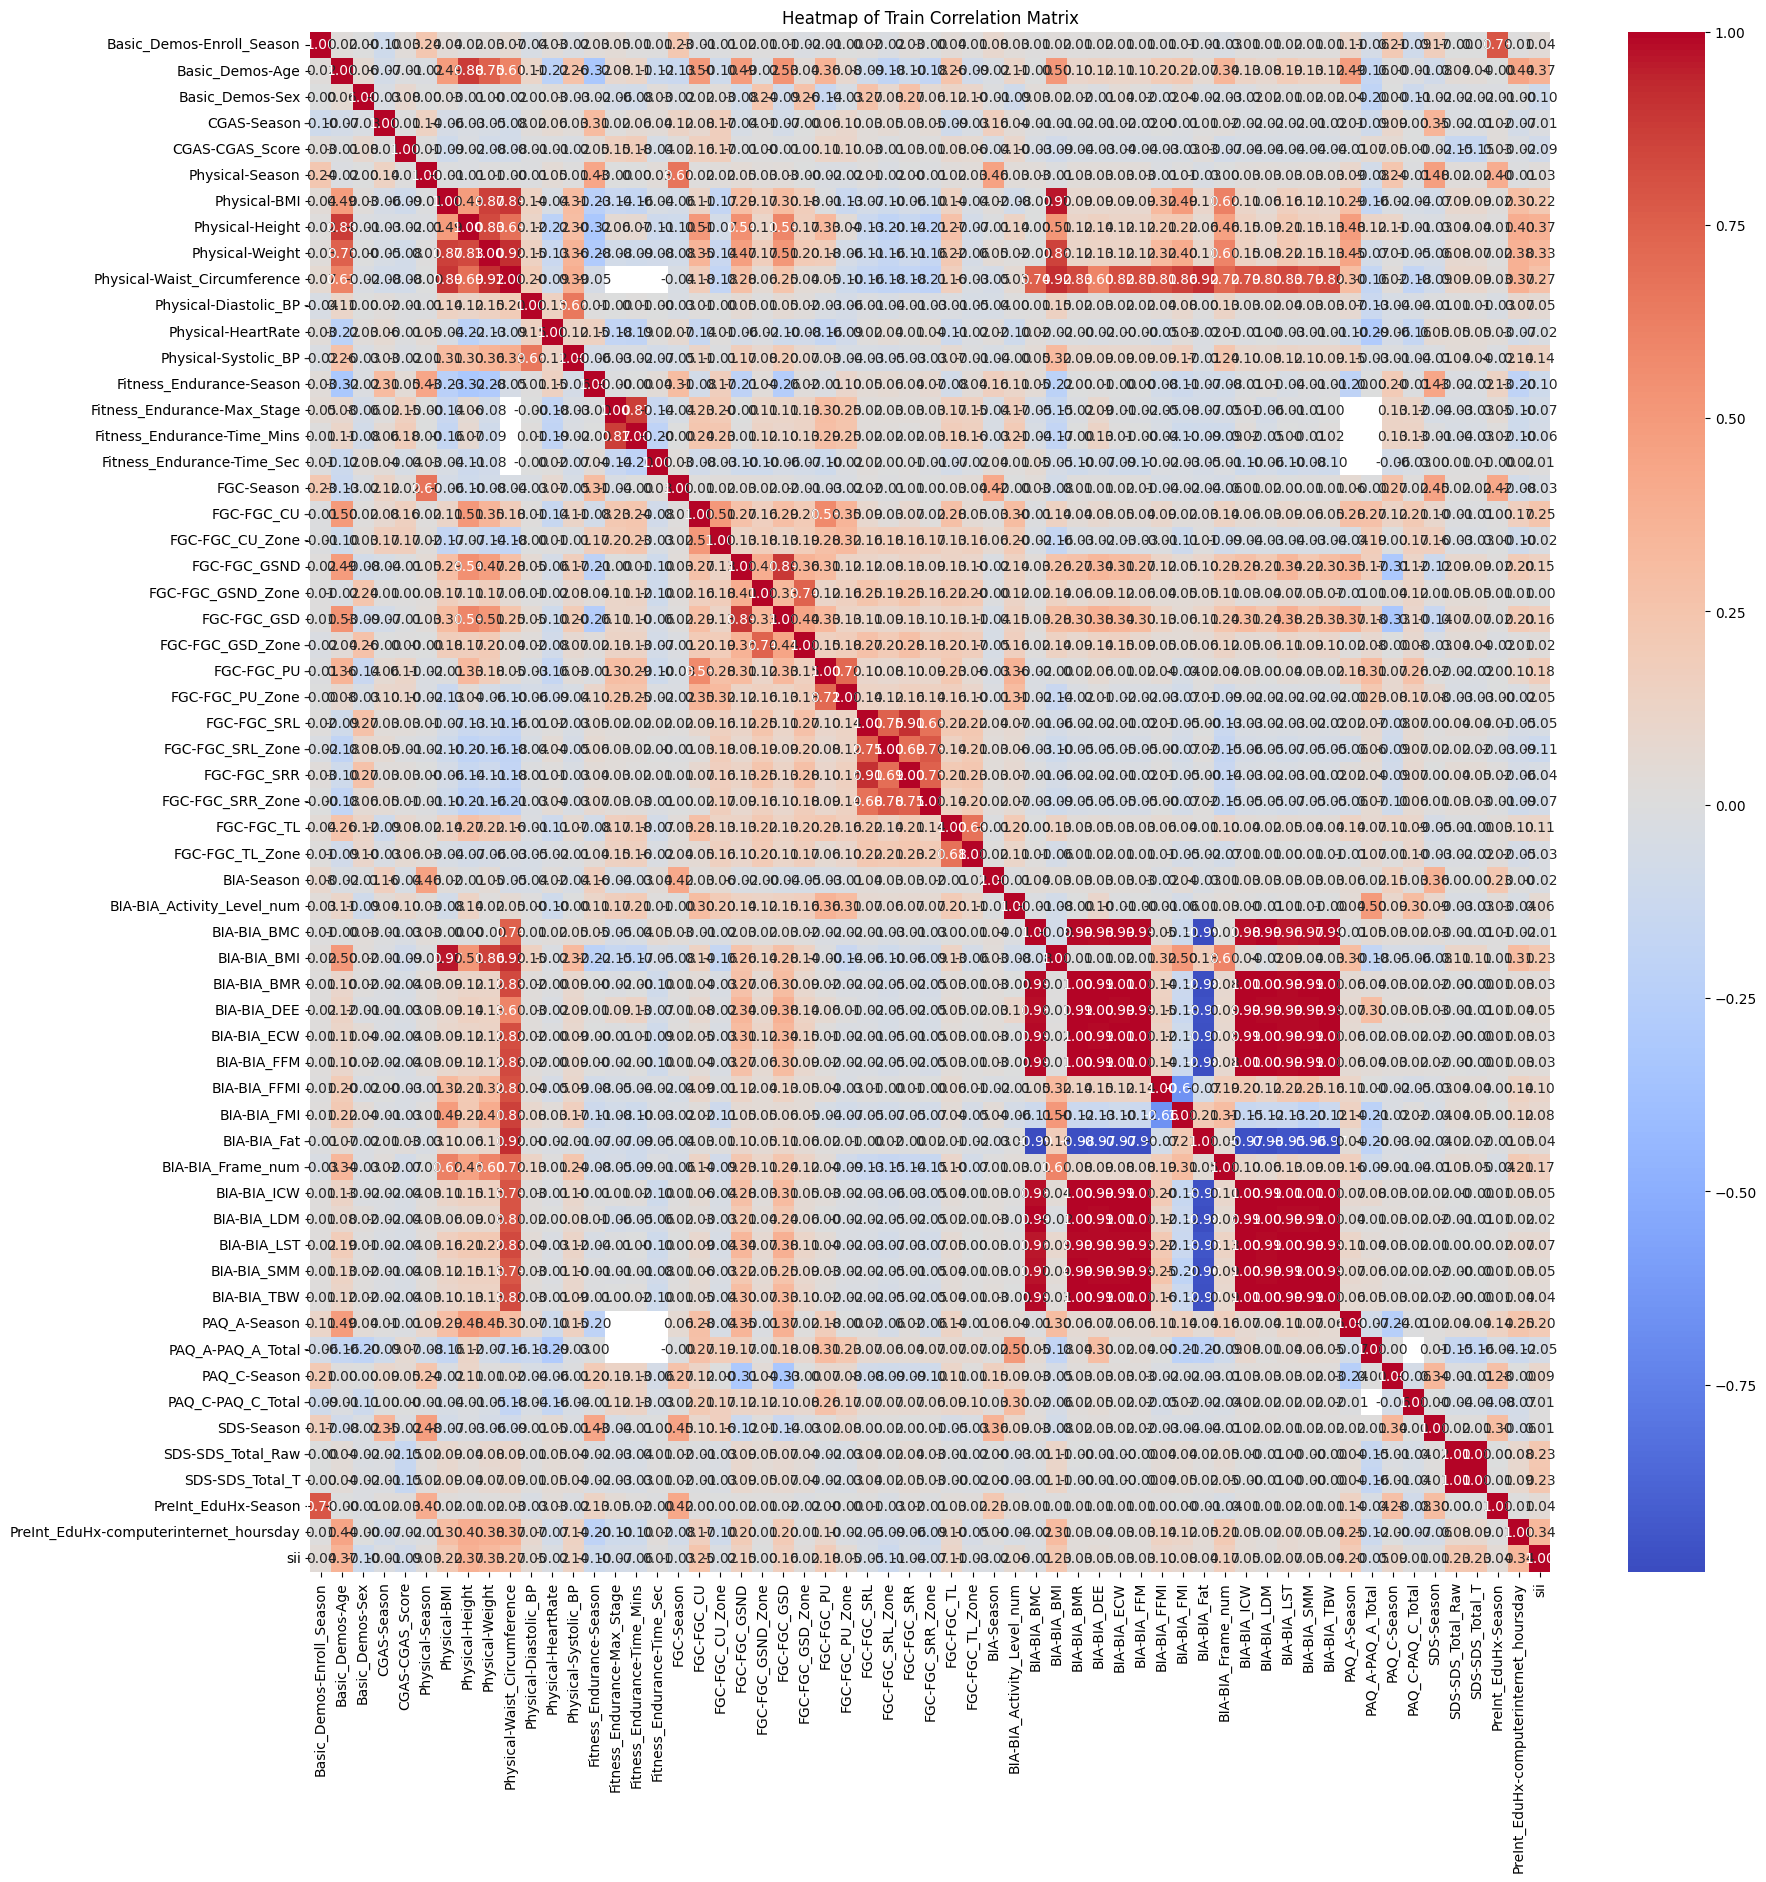

In [14]:
corr_train_matrix = train_no_id.corr()

# Vẽ heatmap
plt.figure(figsize=(20, 20))
sns.heatmap(corr_train_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Heatmap of Train Correlation Matrix")
plt.show()

In [15]:
def feature_engineering(df_):
    df = df_.copy()
    # Các chỉ số liên quan giữa thể chất và thời gian dùng internet
    df['BMI_Age'] = df['Physical-BMI'] * df['Basic_Demos-Age']
    df['Internet_Hours_Age'] = df['PreInt_EduHx-computerinternet_hoursday'] * df['Basic_Demos-Age']
    df['BMI_Internet_Hours'] = df['Physical-BMI'] * df['PreInt_EduHx-computerinternet_hoursday']
    
    # Tỉ lệ lượng mỡ
    df['BFP_BMI'] = df['BIA-BIA_Fat'] / df['BIA-BIA_BMI']
    # Quan hệ giữa cơ và mỡ
    df['FFMI_BFP'] = df['BIA-BIA_FFMI'] / df['BIA-BIA_Fat']
    # Quan hệ giữa mỡ cơ thể và mỡ tổng thế
    df['FMI_BFP'] = df['BIA-BIA_FMI'] / df['BIA-BIA_Fat']
    # Tỷ lệ mô mềm và lượng nước
    df['LST_TBW'] = df['BIA-BIA_LST'] / df['BIA-BIA_TBW']
    # Mỡ * Tốc độ chuyển hóa
    df['BFP_BMR'] = df['BIA-BIA_Fat'] * df['BIA-BIA_BMR']
    # Mỡ * Mức năng lượng
    df['BFP_DEE'] = df['BIA-BIA_Fat'] * df['BIA-BIA_DEE']
    # Tỷ lệ BMR với cân nặng
    df['BMR_Weight'] = df['BIA-BIA_BMR'] / df['Physical-Weight']
    # Tỷ lệ tiêu thụ năng lượng và cân nặng
    df['DEE_Weight'] = df['BIA-BIA_DEE'] / df['Physical-Weight']
    # Tỷ lệ phát triển cơ bắp và chiều cao
    df['SMM_Height'] = df['BIA-BIA_SMM'] / df['Physical-Height']
    # Tỷ lệ co bắp xương / cân nặng
    df['Muscle_to_Fat'] = df['BIA-BIA_SMM'] / df['BIA-BIA_FMI']
    # Mức độ Hydrat hóa cơ thể
    df['Hydration_Status'] = df['BIA-BIA_TBW'] / df['Physical-Weight']
    
    df['ICW_TBW'] = df['BIA-BIA_ICW'] / df['BIA-BIA_TBW']
    
    df['BMI_PHR'] = df['Physical-BMI'] * df['Physical-HeartRate']
    return df

In [16]:
def season_encode(df, kill_season=False):
    if kill_season:
        season_cols = [col for col in df.columns if 'Season' in col]
        df_ = df.drop(season_cols, axis=1)
        return df_
        
    df_no_id = df.drop(columns='id')
    string_columns = df_no_id.select_dtypes(include=['object']).columns.tolist()
    
    season_encode_map = {
        'Spring': 1,
        'Summer': 2,
        'Fall': 3,
        'Winter': 4,
        np.nan: 0
    }

    df_no_id[string_columns] = df_no_id[string_columns].apply(lambda col: col.map(season_encode_map))
    df_no_id['id'] = df['id']
    return df_no_id

In [17]:
class AutoEncoder(nn.Module):
    def __init__(self, input_dim, encoding_dim):
        super(AutoEncoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, encoding_dim*3),
            nn.ReLU(),
            nn.Linear(encoding_dim*3, encoding_dim*2),
            nn.ReLU(),
            nn.Linear(encoding_dim*2, encoding_dim),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(encoding_dim, input_dim*2),
            nn.ReLU(),
            nn.Linear(input_dim*2, input_dim*3),
            nn.ReLU(),
            nn.Linear(input_dim*3, input_dim),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [18]:
def perform_autoencoder(df, encoding_dim=50, epochs=50, batch_size=32):
    scaler = StandardScaler()
    df_scaled = scaler.fit_transform(df)

    data_tensor = torch.FloatTensor(df_scaled)
    input_dim = data_tensor.shape[1]
    autoencoder = AutoEncoder(input_dim, encoding_dim)

    criterior = nn.MSELoss()
    optimizer = optim.Adam(autoencoder.parameters())

    for epoch in range(epochs):
        for i in range(0, len(data_tensor), batch_size):
            batch = data_tensor[i : i + batch_size]
            optimizer.zero_grad()
            output = autoencoder(batch)
            loss = criterior(output, batch)
            loss.backward()
            optimizer.step()

        if (epoch + 1)%10 == 0:
            print(f'Epoch [{epoch + 1}/{epochs}], Loss: {loss.item():.4f}]')

    with torch.no_grad():
        encoded_data = autoencoder.encoder(data_tensor).numpy()
        
    df_encoded = pd.DataFrame(encoded_data, columns=[f'Enc_{i + 1}' for i in range(encoded_data.shape[1])])
    
    return df_encoded

In [19]:
df_train = train_ts.drop('id', axis=1)
df_test = test_ts.drop('id', axis=1)

print("Train encode")
train_ts_encoded = perform_autoencoder(df_train, encoding_dim=70, epochs=200, batch_size=32)
print("Test encode")
test_ts_encoded = perform_autoencoder(df_test, encoding_dim=70, epochs=200, batch_size=32)

Train encode
Epoch [10/200], Loss: 1.6188]
Epoch [20/200], Loss: 1.5670]
Epoch [30/200], Loss: 1.5363]
Epoch [40/200], Loss: 1.5248]
Epoch [50/200], Loss: 1.5205]
Epoch [60/200], Loss: 1.5231]
Epoch [70/200], Loss: 1.5173]
Epoch [80/200], Loss: 1.5052]
Epoch [90/200], Loss: 1.5065]
Epoch [100/200], Loss: 1.4995]
Epoch [110/200], Loss: 1.4615]
Epoch [120/200], Loss: 1.4136]
Epoch [130/200], Loss: 1.4087]
Epoch [140/200], Loss: 1.4016]
Epoch [150/200], Loss: 1.3832]
Epoch [160/200], Loss: 1.3656]
Epoch [170/200], Loss: 1.3646]
Epoch [180/200], Loss: 1.3593]
Epoch [190/200], Loss: 1.3431]
Epoch [200/200], Loss: 1.3471]
Test encode
Epoch [10/200], Loss: 1.0038]
Epoch [20/200], Loss: 0.5369]
Epoch [30/200], Loss: 0.4271]
Epoch [40/200], Loss: 0.4271]
Epoch [50/200], Loss: 0.4271]
Epoch [60/200], Loss: 0.4271]
Epoch [70/200], Loss: 0.4271]
Epoch [80/200], Loss: 0.4271]
Epoch [90/200], Loss: 0.4271]
Epoch [100/200], Loss: 0.4271]
Epoch [110/200], Loss: 0.4271]
Epoch [120/200], Loss: 0.4271]
E

In [20]:
# Lấy lại id
train_ts_encoded["id"]=train_ts["id"]
test_ts_encoded['id']=test_ts["id"]

In [21]:
# Hợp nhất dữ liệu dựa trên id
train_has_season = season_encode(train, kill_season=True)
test_has_season = season_encode(test, kill_season=True)

train_combine = pd.merge(train_has_season, train_ts_encoded, how="left", on='id')
test_combine = pd.merge(test_has_season, test_ts_encoded, how="left", on='id')

In [22]:
# Sử dụng KNN
imputer = KNNImputer(n_neighbors=5)
numeric_cols_train = train_combine.select_dtypes(include=['int32', 'int64', 'float64']).columns
numeric_cols_test = test_combine.select_dtypes(include=['int32', 'int64', 'float64']).columns

imputed_data_train = imputer.fit_transform(train_combine[numeric_cols_train])
imputed_data_test = imputer.fit_transform(test_combine[numeric_cols_test])

train_imputed = pd.DataFrame(imputed_data_train, columns=numeric_cols_train)
test_imputed = pd.DataFrame(imputed_data_test, columns=numeric_cols_test)

train_imputed['sii'] = train_imputed['sii'].round().astype(int)
for col in train_combine.columns:
    if col not in numeric_cols_train:
        train_imputed[col] = train_combine[col]
for col in test_combine.columns:
    if col not in numeric_cols_test:
        test_imputed[col] = test_combine[col]

## Xử lý dữ liệu sau khi fill
train_combine = train_imputed
test_combine = test_imputed
train_combine = feature_engineering(train_combine)
test_combine = feature_engineering(test_combine)

## Loại bỏ cột id ở cả 2 tập
train_combine.drop(columns=['id'], inplace=True)
test_combine.drop(columns=['id'], inplace=True)

In [23]:
train_combine.replace([np.inf, -np.inf], 0, inplace=True)
test_combine.replace([np.inf, -np.inf], 0, inplace=True)

TRAIN SIMPLE XGBOOST

In [24]:
## Hyperparameters
N_SPLITS = 5
SEED = 42

In [25]:
## Useful function
def quadratic_weighted_kappa(y_true, y_pred):
    return cohen_kappa_score(y_true, y_pred, weights='quadratic')

def threshold_Rounder(oof_non_rounded, thresholds):
    return np.where(oof_non_rounded < thresholds[0], 0,
                    np.where(oof_non_rounded < thresholds[1], 1,
                             np.where(oof_non_rounded < thresholds[2], 2, 3)))
    
def evaluate_predictions(thresholds, y_true, oof_non_rounded):
    rounded_p = threshold_Rounder(oof_non_rounded, thresholds)
    return -quadratic_weighted_kappa(y_true, rounded_p)

In [26]:
## Train and get predict function
def train_predict(model, train_data, test_data):
    # Khớp giữ liệu input của train và test
    X = train_data.drop(columns=['sii'])
    y = train_data['sii']

    # Định nghĩa K-Fold
    SKF = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=SEED)

    train_his = []
    val_his = []

    oof_non_rounded = np.zeros(len(y), dtype=float) 
    oof_rounded = np.zeros(len(y), dtype=int) 
    test_preds = np.zeros((len(test_data), N_SPLITS))

    for fold, (train_index, val_index) in enumerate(tqdm(SKF.split(X, y), desc="Train progress", total = N_SPLITS)):
        # Xác định dữ liệu của fold
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]
        # Train
        model_ = clone(model) # tạo bản sao làm mới tại mỗi fold -> độc lập
        model_.fit(X_train, y_train)

        # Tính toán sai số
        y_train_pred = model_.predict(X_train)
        y_val_pred = model_.predict(X_val)

        oof_non_rounded[val_index] = y_val_pred
        y_train_pred_rounded = y_train_pred.round(0).astype(int)
        y_val_pred_rounded = y_val_pred.round(0).astype(int)
        oof_rounded[val_index] = y_val_pred_rounded

        # Kiểm tra sai số giữa mô hình đánh giá và thực tế
        train_kappa = quadratic_weighted_kappa(y_train, y_train_pred_rounded)
        val_kappa = quadratic_weighted_kappa(y_val, y_val_pred_rounded)

        train_his.append(train_kappa)
        val_his.append(val_kappa)

        test_preds[:, fold] = model_.predict(test_data)
        
        print(f"Fold {fold+1} - Train QWK: {train_kappa:.4f}, Validation QWK: {val_kappa:.4f}")

    print(f"Mean Train QWK --> {np.mean(train_his):.4f}")
    print(f"Mean Validation QWK ---> {np.mean(val_his):.4f}")

    KappaOPtimizer = minimize(evaluate_predictions,
                              x0=[0.5, 1.5, 2.5], args=(y, oof_non_rounded), 
                              method='Nelder-Mead')
    
    oof_tuned = threshold_Rounder(oof_non_rounded, KappaOPtimizer.x)
    tKappa = quadratic_weighted_kappa(y, oof_tuned)

    print(f"----> || Optimized QWK SCORE :: {Fore.CYAN}{Style.BRIGHT} {tKappa:.3f}{Style.RESET_ALL}")

    tpm = test_preds.mean(axis=1)
    tpTuned = threshold_Rounder(tpm, KappaOPtimizer.x)
    
    submission = pd.DataFrame({
        'id': sample['id'],
        'sii': tpTuned
    })

    return submission, model_, np.mean(val_his)

In [27]:
MODEL_BOUNDS = {
    'LightGBM': {
        'learning_rate': (0.01, 0.1),          # Từ rất thấp đến trung bình
        'max_depth': (6, 15),                 # Từ sâu vừa đến sâu hơn
        'num_leaves': (50, 500),              # Số lượng leaves lớn
        'min_data_in_leaf': (5, 50),          # Giới hạn dữ liệu tối thiểu
        'feature_fraction': (0.5, 1.0),       # Randomly select features
        'bagging_fraction': (0.5, 1.0),       # Randomly sample data
        'bagging_freq': (1, 10),              # Tần suất của bagging
        'lambda_l1': (0, 10),                 # Regularization L1
        'lambda_l2': (0, 10),                 # Regularization L2
    },
    'XGBoost': {
        'learning_rate': (0.01, 0.1),         # Học chậm để ổn định
        'max_depth': (3, 15),                 # Từ cây nông đến sâu
        'n_estimators': (50, 300),            # Số lượng cây
        'subsample': (0.5, 1.0),              # Tỷ lệ dữ liệu ngẫu nhiên
        'colsample_bytree': (0.5, 1.0),       # Tỷ lệ cột được chọn ngẫu nhiên
        'reg_alpha': (0, 10),                 # Regularization L1
        'reg_lambda': (0, 10),                # Regularization L2
    },
    'CatBoost': {
        'learning_rate': (0.01, 0.1),         # Tốc độ học
        'depth': (4, 10),                     # Độ sâu của cây
        'iterations': (100, 500),             # Số vòng lặp (iterations)
        'l2_leaf_reg': (1, 10),               # Regularization L2
    }
}

MUST_INT_PARAMS = {
    'LightGBM': ['max_depth', 'num_leaves', 'min_data_in_leaf', 'bagging_freq'],
    'XGBoost': ['max_depth', 'n_estimators'],
    'CatBoost': ['depth', 'iterations']
}

In [28]:
def bayesian_optimization(model: str):
    def objective(**args):
        params = args
        for key in MUST_INT_PARAMS[model]:
            params[key] = int(params[key])
            
        if model == 'LightGBM':
            model_instance = LGBMRegressor(**params, n_estimators=200, verbose=-1, random_state=SEED)
        elif model == 'XGBoost':
            model_instance = XGBRegressor(**params, tree_method='gpu_hist', random_state=SEED)
        elif model == 'CatBoost':
            model_instance = CatBoostRegressor(**params, task_type='GPU', verbose=0, random_seed=SEED)
        else:
            raise ValueError(f"Model {model} is not supported!")
            
        _,_, val_score = train_predict(model_instance, train_combine, test_combine)
        return -np.mean(val_score)

    optimizer = BayesianOptimization(
        f=objective,
        pbounds=MODEL_BOUNDS[model],
        random_state=SEED,
        verbose=-1
    )

    optimizer.maximize(init_points=20, n_iter=20)
    best_params = optimizer.max['params']
    for key in MUST_INT_PARAMS[model]:
        best_params[key] = int(best_params[key])

    return best_params

In [29]:
# # Lấy tham số tối ưu từ hàm
# XGBoost_params = bayesian_optimization('XGBoost')
# # Tạo mô hình
# XGBoost_Model = XGBRegressor(**XGBoost_params, tree_method='gpu_hist', random_state=SEED)

In [30]:
# Submission1, model, val = train_predict(XGBoost_Model, train_combine, test_combine)
# Submission1['sii'].value_counts()
# Submission1.to_csv('submission.csv', index=False)

In [31]:
# Lấy tham số tối ưu từ hàm
LightGBM_params = bayesian_optimization('LightGBM')
# Tạo mô hình
LightGBM_Model = LGBMRegressor(**LightGBM_params, n_estimators=200, verbose=-1, random_state=SEED)

|   iter    |  target   | baggin... | baggin... | featur... | lambda_l1 | lambda_l2 | learni... | max_depth | min_da... | num_le... |
-------------------------------------------------------------------------------------------------------------------------------------


Train progress:  20%|██        | 1/5 [00:00<00:02,  1.61it/s]

Fold 1 - Train QWK: 0.5897, Validation QWK: 0.4463


Train progress:  40%|████      | 2/5 [00:01<00:01,  1.72it/s]

Fold 2 - Train QWK: 0.5923, Validation QWK: 0.3989


Train progress:  60%|██████    | 3/5 [00:01<00:01,  1.72it/s]

Fold 3 - Train QWK: 0.5737, Validation QWK: 0.4563


Train progress:  80%|████████  | 4/5 [00:02<00:00,  1.73it/s]

Fold 4 - Train QWK: 0.5976, Validation QWK: 0.4353


Train progress: 100%|██████████| 5/5 [00:02<00:00,  1.72it/s]


Fold 5 - Train QWK: 0.5939, Validation QWK: 0.4661
Mean Train QWK --> 0.5894
Mean Validation QWK ---> 0.4406
----> || Optimized QWK SCORE ::  0.504
| 1         | -0.4406   | 0.6873    | 9.556     | 0.866     | 5.987     | 1.56      | 0.02404   | 6.523     | 43.98     | 320.5     |


Train progress:  20%|██        | 1/5 [00:01<00:04,  1.15s/it]

Fold 1 - Train QWK: 0.6700, Validation QWK: 0.4564


Train progress:  40%|████      | 2/5 [00:02<00:03,  1.03s/it]

Fold 2 - Train QWK: 0.6855, Validation QWK: 0.4172


Train progress:  60%|██████    | 3/5 [00:03<00:02,  1.02s/it]

Fold 3 - Train QWK: 0.6730, Validation QWK: 0.4399


Train progress:  80%|████████  | 4/5 [00:04<00:01,  1.01s/it]

Fold 4 - Train QWK: 0.6905, Validation QWK: 0.4774


Train progress: 100%|██████████| 5/5 [00:05<00:00,  1.02s/it]


Fold 5 - Train QWK: 0.6755, Validation QWK: 0.4891
Mean Train QWK --> 0.6789
Mean Validation QWK ---> 0.4560
----> || Optimized QWK SCORE ::  0.505
| 2         | -0.456    | 0.854     | 1.185     | 0.985     | 8.324     | 2.123     | 0.02636   | 7.651     | 18.69     | 286.1     |


Train progress:  20%|██        | 1/5 [00:00<00:03,  1.12it/s]

Fold 1 - Train QWK: 0.8028, Validation QWK: 0.4713


Train progress:  40%|████      | 2/5 [00:01<00:02,  1.17it/s]

Fold 2 - Train QWK: 0.8038, Validation QWK: 0.4316


Train progress:  60%|██████    | 3/5 [00:02<00:01,  1.14it/s]

Fold 3 - Train QWK: 0.8074, Validation QWK: 0.4325


Train progress:  80%|████████  | 4/5 [00:03<00:01,  1.00s/it]

Fold 4 - Train QWK: 0.8062, Validation QWK: 0.4315


Train progress: 100%|██████████| 5/5 [00:04<00:00,  1.03it/s]


Fold 5 - Train QWK: 0.7949, Validation QWK: 0.4677
Mean Train QWK --> 0.8030
Mean Validation QWK ---> 0.4469
----> || Optimized QWK SCORE ::  0.490
| 3         | -0.4469   | 0.716     | 3.621     | 0.8059    | 1.395     | 2.921     | 0.04297   | 10.1      | 40.33     | 139.9     |


Train progress:  20%|██        | 1/5 [00:00<00:02,  1.70it/s]

Fold 1 - Train QWK: 0.5441, Validation QWK: 0.4577


Train progress:  40%|████      | 2/5 [00:01<00:01,  1.91it/s]

Fold 2 - Train QWK: 0.5540, Validation QWK: 0.3970


Train progress:  60%|██████    | 3/5 [00:01<00:01,  1.93it/s]

Fold 3 - Train QWK: 0.5361, Validation QWK: 0.4232


Train progress:  80%|████████  | 4/5 [00:02<00:00,  1.96it/s]

Fold 4 - Train QWK: 0.5524, Validation QWK: 0.4383


Train progress: 100%|██████████| 5/5 [00:02<00:00,  1.94it/s]


Fold 5 - Train QWK: 0.5423, Validation QWK: 0.4568
Mean Train QWK --> 0.5458
Mean Validation QWK ---> 0.4346
----> || Optimized QWK SCORE ::  0.502
| 4         | -0.4346   | 0.7571    | 6.332     | 0.5232    | 6.075     | 1.705     | 0.01585   | 14.54     | 48.45     | 413.8     |


Train progress:  20%|██        | 1/5 [00:00<00:02,  1.74it/s]

Fold 1 - Train QWK: 0.7137, Validation QWK: 0.4720


Train progress:  40%|████      | 2/5 [00:01<00:01,  1.82it/s]

Fold 2 - Train QWK: 0.7245, Validation QWK: 0.4068


Train progress:  60%|██████    | 3/5 [00:01<00:01,  1.80it/s]

Fold 3 - Train QWK: 0.7107, Validation QWK: 0.4511


Train progress:  80%|████████  | 4/5 [00:02<00:00,  1.78it/s]

Fold 4 - Train QWK: 0.7171, Validation QWK: 0.4474


Train progress: 100%|██████████| 5/5 [00:02<00:00,  1.78it/s]


Fold 5 - Train QWK: 0.7116, Validation QWK: 0.5052
Mean Train QWK --> 0.7155
Mean Validation QWK ---> 0.4565
----> || Optimized QWK SCORE ::  0.498
| 5         | -0.4565   | 0.6523    | 1.879     | 0.8421    | 4.402     | 1.22      | 0.05457   | 6.309     | 45.92     | 166.5     |


Train progress:  20%|██        | 1/5 [00:00<00:03,  1.28it/s]

Fold 1 - Train QWK: 0.8762, Validation QWK: 0.4862


Train progress:  40%|████      | 2/5 [00:01<00:02,  1.34it/s]

Fold 2 - Train QWK: 0.8767, Validation QWK: 0.4166


Train progress:  60%|██████    | 3/5 [00:02<00:01,  1.32it/s]

Fold 3 - Train QWK: 0.8746, Validation QWK: 0.4467


Train progress:  80%|████████  | 4/5 [00:03<00:00,  1.31it/s]

Fold 4 - Train QWK: 0.8764, Validation QWK: 0.4354


Train progress: 100%|██████████| 5/5 [00:03<00:00,  1.32it/s]


Fold 5 - Train QWK: 0.8697, Validation QWK: 0.4861
Mean Train QWK --> 0.8747
Mean Validation QWK ---> 0.4542
----> || Optimized QWK SCORE ::  0.487
| 6         | -0.4542   | 0.8313    | 3.805     | 0.76      | 5.467     | 1.849     | 0.09726   | 12.98     | 47.28     | 452.7     |


Train progress:  20%|██        | 1/5 [00:01<00:04,  1.13s/it]

Fold 1 - Train QWK: 0.8987, Validation QWK: 0.4725


Train progress:  40%|████      | 2/5 [00:02<00:03,  1.05s/it]

Fold 2 - Train QWK: 0.8965, Validation QWK: 0.4248


Train progress:  60%|██████    | 3/5 [00:03<00:02,  1.05s/it]

Fold 3 - Train QWK: 0.8864, Validation QWK: 0.4300


Train progress:  80%|████████  | 4/5 [00:04<00:01,  1.05s/it]

Fold 4 - Train QWK: 0.8961, Validation QWK: 0.4543


Train progress: 100%|██████████| 5/5 [00:05<00:00,  1.05s/it]


Fold 5 - Train QWK: 0.8874, Validation QWK: 0.4759
Mean Train QWK --> 0.8930
Mean Validation QWK ---> 0.4515
----> || Optimized QWK SCORE ::  0.493
| 7         | -0.4515   | 0.7989    | 9.297     | 0.5442    | 1.96      | 0.4523    | 0.03928   | 9.498     | 17.21     | 422.9     |


Train progress:  20%|██        | 1/5 [00:00<00:03,  1.19it/s]

Fold 1 - Train QWK: 0.6298, Validation QWK: 0.4631


Train progress:  40%|████      | 2/5 [00:01<00:02,  1.25it/s]

Fold 2 - Train QWK: 0.6310, Validation QWK: 0.4163


Train progress:  60%|██████    | 3/5 [00:02<00:01,  1.22it/s]

Fold 3 - Train QWK: 0.6180, Validation QWK: 0.4336


Train progress:  80%|████████  | 4/5 [00:03<00:00,  1.18it/s]

Fold 4 - Train QWK: 0.6414, Validation QWK: 0.4417


Train progress: 100%|██████████| 5/5 [00:04<00:00,  1.20it/s]


Fold 5 - Train QWK: 0.6306, Validation QWK: 0.4639
Mean Train QWK --> 0.6301
Mean Validation QWK ---> 0.4437
----> || Optimized QWK SCORE ::  0.501
| 8         | -0.4437   | 0.6784    | 3.528     | 0.7713    | 1.409     | 8.022     | 0.01671   | 14.88     | 39.75     | 139.4     |


Train progress:  20%|██        | 1/5 [00:00<00:03,  1.06it/s]

Fold 1 - Train QWK: 0.5839, Validation QWK: 0.4771


Train progress:  40%|████      | 2/5 [00:01<00:02,  1.07it/s]

Fold 2 - Train QWK: 0.5831, Validation QWK: 0.4035


Train progress:  60%|██████    | 3/5 [00:02<00:01,  1.08it/s]

Fold 3 - Train QWK: 0.5705, Validation QWK: 0.4336


Train progress:  80%|████████  | 4/5 [00:03<00:00,  1.09it/s]

Fold 4 - Train QWK: 0.5989, Validation QWK: 0.4604


Train progress: 100%|██████████| 5/5 [00:04<00:00,  1.09it/s]


Fold 5 - Train QWK: 0.5901, Validation QWK: 0.4591
Mean Train QWK --> 0.5853
Mean Validation QWK ---> 0.4467
----> || Optimized QWK SCORE ::  0.503
| 9         | -0.4467   | 0.5028    | 8.339     | 0.8534    | 7.29      | 7.713     | 0.01666   | 9.226     | 10.21     | 438.4     |


Train progress:  20%|██        | 1/5 [00:00<00:02,  1.40it/s]

Fold 1 - Train QWK: 0.8746, Validation QWK: 0.4749


Train progress:  40%|████      | 2/5 [00:01<00:02,  1.46it/s]

Fold 2 - Train QWK: 0.8796, Validation QWK: 0.4440


Train progress:  60%|██████    | 3/5 [00:02<00:01,  1.43it/s]

Fold 3 - Train QWK: 0.8750, Validation QWK: 0.4453


Train progress:  80%|████████  | 4/5 [00:02<00:00,  1.42it/s]

Fold 4 - Train QWK: 0.8804, Validation QWK: 0.4435


Train progress: 100%|██████████| 5/5 [00:03<00:00,  1.42it/s]


Fold 5 - Train QWK: 0.8859, Validation QWK: 0.4772
Mean Train QWK --> 0.8791
Mean Validation QWK ---> 0.4570
----> || Optimized QWK SCORE ::  0.493
| 10        | -0.457    | 0.8116    | 3.978     | 0.5318    | 3.11      | 3.252     | 0.07566   | 11.74     | 44.92     | 262.5     |


Train progress:  20%|██        | 1/5 [00:00<00:03,  1.20it/s]

Fold 1 - Train QWK: 0.7522, Validation QWK: 0.4726


Train progress:  40%|████      | 2/5 [00:01<00:02,  1.25it/s]

Fold 2 - Train QWK: 0.7669, Validation QWK: 0.4243


Train progress:  60%|██████    | 3/5 [00:02<00:01,  1.22it/s]

Fold 3 - Train QWK: 0.7591, Validation QWK: 0.4340


Train progress:  80%|████████  | 4/5 [00:03<00:00,  1.08it/s]

Fold 4 - Train QWK: 0.7614, Validation QWK: 0.4425


Train progress: 100%|██████████| 5/5 [00:04<00:00,  1.10it/s]


Fold 5 - Train QWK: 0.7575, Validation QWK: 0.5115
Mean Train QWK --> 0.7594
Mean Validation QWK ---> 0.4570
----> || Optimized QWK SCORE ::  0.497
| 11        | -0.457    | 0.5598    | 7.419     | 0.8804    | 5.613     | 7.71      | 0.05444   | 10.7      | 24.24     | 61.44     |


Train progress:  20%|██        | 1/5 [00:00<00:03,  1.18it/s]

Fold 1 - Train QWK: 0.8977, Validation QWK: 0.4578


Train progress:  40%|████      | 2/5 [00:01<00:02,  1.22it/s]

Fold 2 - Train QWK: 0.9092, Validation QWK: 0.4137


Train progress:  60%|██████    | 3/5 [00:02<00:01,  1.21it/s]

Fold 3 - Train QWK: 0.9034, Validation QWK: 0.4345


Train progress:  80%|████████  | 4/5 [00:03<00:00,  1.20it/s]

Fold 4 - Train QWK: 0.9067, Validation QWK: 0.4511


Train progress: 100%|██████████| 5/5 [00:04<00:00,  1.20it/s]


Fold 5 - Train QWK: 0.8960, Validation QWK: 0.4964
Mean Train QWK --> 0.9026
Mean Validation QWK ---> 0.4507
----> || Optimized QWK SCORE ::  0.483
| 12        | -0.4507   | 0.5539    | 1.283     | 0.8182    | 3.144     | 5.086     | 0.09168   | 8.244     | 23.47     | 390.0     |


Train progress:  20%|██        | 1/5 [00:00<00:02,  1.47it/s]

Fold 1 - Train QWK: 0.8637, Validation QWK: 0.4750


Train progress:  40%|████      | 2/5 [00:01<00:01,  1.52it/s]

Fold 2 - Train QWK: 0.8640, Validation QWK: 0.4219


Train progress:  60%|██████    | 3/5 [00:02<00:01,  1.49it/s]

Fold 3 - Train QWK: 0.8664, Validation QWK: 0.4362


Train progress:  80%|████████  | 4/5 [00:02<00:00,  1.50it/s]

Fold 4 - Train QWK: 0.8652, Validation QWK: 0.4545


Train progress: 100%|██████████| 5/5 [00:03<00:00,  1.50it/s]


Fold 5 - Train QWK: 0.8598, Validation QWK: 0.4888
Mean Train QWK --> 0.8638
Mean Validation QWK ---> 0.4553
----> || Optimized QWK SCORE ::  0.491
| 13        | -0.4553   | 0.6144    | 1.693     | 0.6449    | 1.612     | 9.297     | 0.08273   | 11.7      | 44.22     | 411.7     |


Train progress:  20%|██        | 1/5 [00:00<00:02,  1.40it/s]

Fold 1 - Train QWK: 0.6445, Validation QWK: 0.4456


Train progress:  40%|████      | 2/5 [00:01<00:02,  1.50it/s]

Fold 2 - Train QWK: 0.6599, Validation QWK: 0.4023


Train progress:  60%|██████    | 3/5 [00:02<00:01,  1.47it/s]

Fold 3 - Train QWK: 0.6487, Validation QWK: 0.4671


Train progress:  80%|████████  | 4/5 [00:02<00:00,  1.46it/s]

Fold 4 - Train QWK: 0.6528, Validation QWK: 0.4534


Train progress: 100%|██████████| 5/5 [00:03<00:00,  1.46it/s]


Fold 5 - Train QWK: 0.6518, Validation QWK: 0.4730
Mean Train QWK --> 0.6515
Mean Validation QWK ---> 0.4483
----> || Optimized QWK SCORE ::  0.495
| 14        | -0.4483   | 0.5933    | 9.033     | 0.7697    | 8.074     | 8.961     | 0.03862   | 6.99      | 15.26     | 242.2     |


Train progress:  20%|██        | 1/5 [00:00<00:03,  1.31it/s]

Fold 1 - Train QWK: 0.6950, Validation QWK: 0.4618


Train progress:  40%|████      | 2/5 [00:01<00:02,  1.35it/s]

Fold 2 - Train QWK: 0.7200, Validation QWK: 0.4237


Train progress:  60%|██████    | 3/5 [00:02<00:01,  1.27it/s]

Fold 3 - Train QWK: 0.7116, Validation QWK: 0.4435


Train progress:  80%|████████  | 4/5 [00:03<00:00,  1.30it/s]

Fold 4 - Train QWK: 0.7170, Validation QWK: 0.4702


Train progress: 100%|██████████| 5/5 [00:03<00:00,  1.32it/s]


Fold 5 - Train QWK: 0.7008, Validation QWK: 0.4785
Mean Train QWK --> 0.7089
Mean Validation QWK ---> 0.4556
----> || Optimized QWK SCORE ::  0.509
| 15        | -0.4556   | 0.909     | 8.747     | 0.5035    | 5.107     | 4.174     | 0.02999   | 7.079     | 20.19     | 474.3     |


Train progress:  20%|██        | 1/5 [00:00<00:03,  1.15it/s]

Fold 1 - Train QWK: 0.8948, Validation QWK: 0.4719


Train progress:  40%|████      | 2/5 [00:01<00:02,  1.17it/s]

Fold 2 - Train QWK: 0.8971, Validation QWK: 0.4033


Train progress:  60%|██████    | 3/5 [00:02<00:01,  1.16it/s]

Fold 3 - Train QWK: 0.8918, Validation QWK: 0.4271


Train progress:  80%|████████  | 4/5 [00:03<00:00,  1.14it/s]

Fold 4 - Train QWK: 0.8970, Validation QWK: 0.4385


Train progress: 100%|██████████| 5/5 [00:04<00:00,  1.16it/s]


Fold 5 - Train QWK: 0.8977, Validation QWK: 0.4597
Mean Train QWK --> 0.8957
Mean Validation QWK ---> 0.4401
----> || Optimized QWK SCORE ::  0.449
| 16        | -0.4401   | 0.6616    | 5.669     | 0.8515    | 3.636     | 9.718     | 0.09662   | 8.266     | 27.38     | 185.4     |


Train progress:  20%|██        | 1/5 [00:01<00:04,  1.07s/it]

Fold 1 - Train QWK: 0.7978, Validation QWK: 0.4434


Train progress:  40%|████      | 2/5 [00:02<00:03,  1.02s/it]

Fold 2 - Train QWK: 0.8007, Validation QWK: 0.4289


Train progress:  60%|██████    | 3/5 [00:03<00:02,  1.04s/it]

Fold 3 - Train QWK: 0.7966, Validation QWK: 0.4503


Train progress:  80%|████████  | 4/5 [00:04<00:01,  1.05s/it]

Fold 4 - Train QWK: 0.8082, Validation QWK: 0.4681


Train progress: 100%|██████████| 5/5 [00:05<00:00,  1.05s/it]


Fold 5 - Train QWK: 0.7886, Validation QWK: 0.4904
Mean Train QWK --> 0.7984
Mean Validation QWK ---> 0.4562
----> || Optimized QWK SCORE ::  0.500
| 17        | -0.4562   | 0.6424    | 1.332     | 0.8048    | 5.027     | 0.5148    | 0.03508   | 14.17     | 15.78     | 115.2     |


Train progress:  20%|██        | 1/5 [00:00<00:03,  1.13it/s]

Fold 1 - Train QWK: 0.6935, Validation QWK: 0.4834


Train progress:  40%|████      | 2/5 [00:01<00:02,  1.14it/s]

Fold 2 - Train QWK: 0.7088, Validation QWK: 0.4268


Train progress:  60%|██████    | 3/5 [00:02<00:01,  1.17it/s]

Fold 3 - Train QWK: 0.6984, Validation QWK: 0.4522


Train progress:  80%|████████  | 4/5 [00:03<00:00,  1.19it/s]

Fold 4 - Train QWK: 0.7053, Validation QWK: 0.4807


Train progress: 100%|██████████| 5/5 [00:04<00:00,  1.19it/s]


Fold 5 - Train QWK: 0.6838, Validation QWK: 0.4747
Mean Train QWK --> 0.6980
Mean Validation QWK ---> 0.4636
----> || Optimized QWK SCORE ::  0.508
| 18        | -0.4636   | 0.7447    | 9.871     | 0.621     | 6.721     | 7.616     | 0.03139   | 12.55     | 21.55     | 334.5     |


Train progress:  20%|██        | 1/5 [00:00<00:02,  1.60it/s]

Fold 1 - Train QWK: 0.5988, Validation QWK: 0.4602


Train progress:  40%|████      | 2/5 [00:01<00:01,  1.65it/s]

Fold 2 - Train QWK: 0.6085, Validation QWK: 0.4104


Train progress:  60%|██████    | 3/5 [00:01<00:01,  1.50it/s]

Fold 3 - Train QWK: 0.5932, Validation QWK: 0.4380


Train progress:  80%|████████  | 4/5 [00:02<00:00,  1.42it/s]

Fold 4 - Train QWK: 0.6133, Validation QWK: 0.4557


Train progress: 100%|██████████| 5/5 [00:03<00:00,  1.48it/s]


Fold 5 - Train QWK: 0.6087, Validation QWK: 0.4677
Mean Train QWK --> 0.6045
Mean Validation QWK ---> 0.4464
----> || Optimized QWK SCORE ::  0.503
| 19        | -0.4464   | 0.8168    | 5.822     | 0.5451    | 8.353     | 3.208     | 0.02679   | 6.367     | 31.59     | 354.9     |


Train progress:  20%|██        | 1/5 [00:00<00:01,  2.21it/s]

Fold 1 - Train QWK: 0.6905, Validation QWK: 0.4641


Train progress:  40%|████      | 2/5 [00:00<00:01,  2.32it/s]

Fold 2 - Train QWK: 0.7084, Validation QWK: 0.4190


Train progress:  60%|██████    | 3/5 [00:01<00:00,  2.28it/s]

Fold 3 - Train QWK: 0.6965, Validation QWK: 0.4389


Train progress:  80%|████████  | 4/5 [00:01<00:00,  2.28it/s]

Fold 4 - Train QWK: 0.6997, Validation QWK: 0.4435


Train progress: 100%|██████████| 5/5 [00:02<00:00,  2.28it/s]

Fold 5 - Train QWK: 0.6992, Validation QWK: 0.4882
Mean Train QWK --> 0.6989
Mean Validation QWK ---> 0.4508
----> || Optimized QWK SCORE ::  0.491
| 20        | -0.4508   | 0.5083    | 5.609     | 0.6132    | 6.452     | 1.744     | 0.07218   | 9.481     | 47.15     | 111.9     |



Train progress:  20%|██        | 1/5 [00:00<00:02,  1.81it/s]

Fold 1 - Train QWK: 0.7380, Validation QWK: 0.4727


Train progress:  40%|████      | 2/5 [00:01<00:01,  1.88it/s]

Fold 2 - Train QWK: 0.7463, Validation QWK: 0.4447


Train progress:  60%|██████    | 3/5 [00:01<00:01,  1.88it/s]

Fold 3 - Train QWK: 0.7290, Validation QWK: 0.4680


Train progress:  80%|████████  | 4/5 [00:02<00:00,  1.76it/s]

Fold 4 - Train QWK: 0.7444, Validation QWK: 0.4327


Train progress: 100%|██████████| 5/5 [00:02<00:00,  1.82it/s]

Fold 5 - Train QWK: 0.7317, Validation QWK: 0.4892
Mean Train QWK --> 0.7379
Mean Validation QWK ---> 0.4615
----> || Optimized QWK SCORE ::  0.498
| 21        | -0.4615   | 0.7897    | 7.206     | 0.5063    | 8.766     | 3.643     | 0.06792   | 7.102     | 30.72     | 355.3     |



Train progress:  20%|██        | 1/5 [00:00<00:02,  1.43it/s]

Fold 1 - Train QWK: 0.7321, Validation QWK: 0.4655


Train progress:  40%|████      | 2/5 [00:01<00:01,  1.53it/s]

Fold 2 - Train QWK: 0.7412, Validation QWK: 0.3994


Train progress:  60%|██████    | 3/5 [00:01<00:01,  1.55it/s]

Fold 3 - Train QWK: 0.7222, Validation QWK: 0.4378


Train progress:  80%|████████  | 4/5 [00:02<00:00,  1.54it/s]

Fold 4 - Train QWK: 0.7359, Validation QWK: 0.4432


Train progress: 100%|██████████| 5/5 [00:03<00:00,  1.53it/s]

Fold 5 - Train QWK: 0.7234, Validation QWK: 0.4712
Mean Train QWK --> 0.7310
Mean Validation QWK ---> 0.4434
----> || Optimized QWK SCORE ::  0.495
| 22        | -0.4434   | 0.8803    | 7.545     | 0.8142    | 0.7545    | 2.827     | 0.04851   | 6.211     | 48.53     | 144.7     |



Train progress:  20%|██        | 1/5 [00:00<00:03,  1.23it/s]

Fold 1 - Train QWK: 0.6444, Validation QWK: 0.4517


Train progress:  40%|████      | 2/5 [00:01<00:02,  1.44it/s]

Fold 2 - Train QWK: 0.6628, Validation QWK: 0.4168


Train progress:  60%|██████    | 3/5 [00:02<00:01,  1.48it/s]

Fold 3 - Train QWK: 0.6578, Validation QWK: 0.4515


Train progress:  80%|████████  | 4/5 [00:02<00:00,  1.39it/s]

Fold 4 - Train QWK: 0.6572, Validation QWK: 0.4709


Train progress: 100%|██████████| 5/5 [00:03<00:00,  1.37it/s]

Fold 5 - Train QWK: 0.6480, Validation QWK: 0.4681
Mean Train QWK --> 0.6540
Mean Validation QWK ---> 0.4518
----> || Optimized QWK SCORE ::  0.506
| 23        | -0.4518   | 0.7191    | 9.586     | 0.5923    | 9.341     | 4.424     | 0.03345   | 11.47     | 23.17     | 229.1     |



Train progress:  20%|██        | 1/5 [00:01<00:07,  1.81s/it]

Fold 1 - Train QWK: 0.8466, Validation QWK: 0.4788


Train progress:  40%|████      | 2/5 [00:03<00:05,  1.79s/it]

Fold 2 - Train QWK: 0.8545, Validation QWK: 0.4150


Train progress:  60%|██████    | 3/5 [00:05<00:03,  1.79s/it]

Fold 3 - Train QWK: 0.8450, Validation QWK: 0.4277


Train progress:  80%|████████  | 4/5 [00:07<00:01,  1.85s/it]

Fold 4 - Train QWK: 0.8568, Validation QWK: 0.4807


Train progress: 100%|██████████| 5/5 [00:09<00:00,  1.82s/it]

Fold 5 - Train QWK: 0.8464, Validation QWK: 0.4894
Mean Train QWK --> 0.8498
Mean Validation QWK ---> 0.4583
----> || Optimized QWK SCORE ::  0.500
| 24        | -0.4583   | 0.563     | 3.199     | 0.8804    | 0.2743    | 8.309     | 0.02552   | 13.77     | 12.47     | 205.4     |



Train progress:  20%|██        | 1/5 [00:01<00:04,  1.12s/it]

Fold 1 - Train QWK: 0.8331, Validation QWK: 0.4814


Train progress:  40%|████      | 2/5 [00:02<00:03,  1.07s/it]

Fold 2 - Train QWK: 0.8403, Validation QWK: 0.4263


Train progress:  60%|██████    | 3/5 [00:03<00:02,  1.09s/it]

Fold 3 - Train QWK: 0.8410, Validation QWK: 0.4403


Train progress:  80%|████████  | 4/5 [00:04<00:01,  1.12s/it]

Fold 4 - Train QWK: 0.8369, Validation QWK: 0.4740


Train progress: 100%|██████████| 5/5 [00:05<00:00,  1.10s/it]


Fold 5 - Train QWK: 0.8328, Validation QWK: 0.4941
Mean Train QWK --> 0.8368
Mean Validation QWK ---> 0.4632
----> || Optimized QWK SCORE ::  0.499
| 25        | -0.4632   | 0.9828    | 6.791     | 0.6607    | 7.598     | 1.215     | 0.04607   | 14.48     | 14.9      | 203.1     |


Train progress:  20%|██        | 1/5 [00:00<00:03,  1.20it/s]

Fold 1 - Train QWK: 0.8731, Validation QWK: 0.4883


Train progress:  40%|████      | 2/5 [00:01<00:02,  1.27it/s]

Fold 2 - Train QWK: 0.8757, Validation QWK: 0.4306


Train progress:  60%|██████    | 3/5 [00:02<00:01,  1.13it/s]

Fold 3 - Train QWK: 0.8686, Validation QWK: 0.4353


Train progress:  80%|████████  | 4/5 [00:03<00:00,  1.09it/s]

Fold 4 - Train QWK: 0.8649, Validation QWK: 0.4732


Train progress: 100%|██████████| 5/5 [00:04<00:00,  1.12it/s]


Fold 5 - Train QWK: 0.8726, Validation QWK: 0.4921
Mean Train QWK --> 0.8710
Mean Validation QWK ---> 0.4639
----> || Optimized QWK SCORE ::  0.495
| 26        | -0.4639   | 0.9444    | 4.752     | 0.5081    | 0.8256    | 9.081     | 0.0605    | 12.79     | 49.04     | 60.36     |


Train progress:  20%|██        | 1/5 [00:01<00:06,  1.62s/it]

Fold 1 - Train QWK: 0.6350, Validation QWK: 0.4628


Train progress:  40%|████      | 2/5 [00:02<00:04,  1.37s/it]

Fold 2 - Train QWK: 0.6311, Validation QWK: 0.4232


Train progress:  60%|██████    | 3/5 [00:04<00:02,  1.37s/it]

Fold 3 - Train QWK: 0.6263, Validation QWK: 0.4654


Train progress:  80%|████████  | 4/5 [00:05<00:01,  1.43s/it]

Fold 4 - Train QWK: 0.6466, Validation QWK: 0.4428


Train progress: 100%|██████████| 5/5 [00:06<00:00,  1.40s/it]

Fold 5 - Train QWK: 0.6384, Validation QWK: 0.4659
Mean Train QWK --> 0.6355
Mean Validation QWK ---> 0.4520
----> || Optimized QWK SCORE ::  0.503
| 27        | -0.452    | 0.5721    | 3.386     | 0.9865    | 9.673     | 6.303     | 0.01971   | 13.82     | 5.54      | 463.4     |



Train progress:  20%|██        | 1/5 [00:00<00:02,  1.82it/s]

Fold 1 - Train QWK: 0.7586, Validation QWK: 0.4742


Train progress:  40%|████      | 2/5 [00:01<00:01,  1.89it/s]

Fold 2 - Train QWK: 0.7672, Validation QWK: 0.4229


Train progress:  60%|██████    | 3/5 [00:01<00:01,  1.87it/s]

Fold 3 - Train QWK: 0.7568, Validation QWK: 0.4489


Train progress:  80%|████████  | 4/5 [00:02<00:00,  1.88it/s]

Fold 4 - Train QWK: 0.7590, Validation QWK: 0.4616


Train progress: 100%|██████████| 5/5 [00:02<00:00,  1.88it/s]

Fold 5 - Train QWK: 0.7531, Validation QWK: 0.4890
Mean Train QWK --> 0.7589
Mean Validation QWK ---> 0.4593
----> || Optimized QWK SCORE ::  0.497
| 28        | -0.4593   | 0.7179    | 9.881     | 0.5052    | 7.734     | 9.504     | 0.07929   | 13.75     | 35.34     | 83.96     |



Train progress:  20%|██        | 1/5 [00:01<00:04,  1.14s/it]

Fold 1 - Train QWK: 0.9139, Validation QWK: 0.4936


Train progress:  40%|████      | 2/5 [00:02<00:03,  1.09s/it]

Fold 2 - Train QWK: 0.9157, Validation QWK: 0.4103


Train progress:  60%|██████    | 3/5 [00:03<00:02,  1.14s/it]

Fold 3 - Train QWK: 0.9189, Validation QWK: 0.4302


Train progress:  80%|████████  | 4/5 [00:04<00:01,  1.11s/it]

Fold 4 - Train QWK: 0.9171, Validation QWK: 0.4257


Train progress: 100%|██████████| 5/5 [00:05<00:00,  1.11s/it]


Fold 5 - Train QWK: 0.9154, Validation QWK: 0.4776
Mean Train QWK --> 0.9162
Mean Validation QWK ---> 0.4475
----> || Optimized QWK SCORE ::  0.480
| 29        | -0.4475   | 0.7406    | 9.219     | 0.8052    | 2.981     | 8.309     | 0.0696    | 13.09     | 26.61     | 277.5     |


Train progress:  20%|██        | 1/5 [00:00<00:03,  1.28it/s]

Fold 1 - Train QWK: 0.7058, Validation QWK: 0.4823


Train progress:  40%|████      | 2/5 [00:01<00:01,  1.53it/s]

Fold 2 - Train QWK: 0.7274, Validation QWK: 0.4200


Train progress:  60%|██████    | 3/5 [00:01<00:01,  1.58it/s]

Fold 3 - Train QWK: 0.7137, Validation QWK: 0.4802


Train progress:  80%|████████  | 4/5 [00:02<00:00,  1.61it/s]

Fold 4 - Train QWK: 0.7246, Validation QWK: 0.4498


Train progress: 100%|██████████| 5/5 [00:03<00:00,  1.59it/s]


Fold 5 - Train QWK: 0.7204, Validation QWK: 0.4879
Mean Train QWK --> 0.7184
Mean Validation QWK ---> 0.4640
----> || Optimized QWK SCORE ::  0.501
| 30        | -0.464    | 0.6046    | 8.097     | 0.8795    | 7.914     | 8.682     | 0.06783   | 8.824     | 39.06     | 317.1     |


Train progress:  20%|██        | 1/5 [00:01<00:04,  1.03s/it]

Fold 1 - Train QWK: 0.8049, Validation QWK: 0.4749


Train progress:  40%|████      | 2/5 [00:01<00:02,  1.02it/s]

Fold 2 - Train QWK: 0.8245, Validation QWK: 0.4347


Train progress:  60%|██████    | 3/5 [00:02<00:01,  1.01it/s]

Fold 3 - Train QWK: 0.8132, Validation QWK: 0.4186


Train progress:  80%|████████  | 4/5 [00:04<00:01,  1.01s/it]

Fold 4 - Train QWK: 0.8156, Validation QWK: 0.4599


Train progress: 100%|██████████| 5/5 [00:05<00:00,  1.01s/it]

Fold 5 - Train QWK: 0.8048, Validation QWK: 0.4803
Mean Train QWK --> 0.8126
Mean Validation QWK ---> 0.4537
----> || Optimized QWK SCORE ::  0.487
| 31        | -0.4537   | 0.6777    | 3.192     | 0.9799    | 2.561     | 0.5447    | 0.04348   | 7.424     | 22.7      | 204.2     |



Train progress:  20%|██        | 1/5 [00:01<00:05,  1.31s/it]

Fold 1 - Train QWK: 0.8026, Validation QWK: 0.4708


Train progress:  40%|████      | 2/5 [00:02<00:03,  1.10s/it]

Fold 2 - Train QWK: 0.7992, Validation QWK: 0.4204


Train progress:  60%|██████    | 3/5 [00:03<00:02,  1.07s/it]

Fold 3 - Train QWK: 0.8034, Validation QWK: 0.4594


Train progress:  80%|████████  | 4/5 [00:04<00:01,  1.04s/it]

Fold 4 - Train QWK: 0.8060, Validation QWK: 0.4575


Train progress: 100%|██████████| 5/5 [00:05<00:00,  1.09s/it]

Fold 5 - Train QWK: 0.7916, Validation QWK: 0.4907
Mean Train QWK --> 0.8005
Mean Validation QWK ---> 0.4598
----> || Optimized QWK SCORE ::  0.503
| 32        | -0.4598   | 0.8673    | 5.265     | 0.6038    | 3.285     | 6.713     | 0.03257   | 9.234     | 20.94     | 161.9     |



Train progress:  20%|██        | 1/5 [00:00<00:03,  1.29it/s]

Fold 1 - Train QWK: 0.6411, Validation QWK: 0.4395


Train progress:  40%|████      | 2/5 [00:01<00:02,  1.48it/s]

Fold 2 - Train QWK: 0.6619, Validation QWK: 0.4097


Train progress:  60%|██████    | 3/5 [00:01<00:01,  1.62it/s]

Fold 3 - Train QWK: 0.6524, Validation QWK: 0.4500


Train progress:  80%|████████  | 4/5 [00:02<00:00,  1.69it/s]

Fold 4 - Train QWK: 0.6525, Validation QWK: 0.4566


Train progress: 100%|██████████| 5/5 [00:03<00:00,  1.64it/s]

Fold 5 - Train QWK: 0.6551, Validation QWK: 0.4700
Mean Train QWK --> 0.6526
Mean Validation QWK ---> 0.4452
----> || Optimized QWK SCORE ::  0.502
| 33        | -0.4452   | 0.5117    | 7.392     | 0.6712    | 5.874     | 3.831     | 0.03997   | 13.83     | 36.25     | 340.5     |



Train progress:  20%|██        | 1/5 [00:01<00:05,  1.41s/it]

Fold 1 - Train QWK: 0.7618, Validation QWK: 0.4731


Train progress:  40%|████      | 2/5 [00:02<00:03,  1.32s/it]

Fold 2 - Train QWK: 0.7650, Validation QWK: 0.4274


Train progress:  60%|██████    | 3/5 [00:04<00:02,  1.35s/it]

Fold 3 - Train QWK: 0.7589, Validation QWK: 0.4355


Train progress:  80%|████████  | 4/5 [00:05<00:01,  1.33s/it]

Fold 4 - Train QWK: 0.7657, Validation QWK: 0.4655


Train progress: 100%|██████████| 5/5 [00:06<00:00,  1.33s/it]

Fold 5 - Train QWK: 0.7505, Validation QWK: 0.4621
Mean Train QWK --> 0.7604
Mean Validation QWK ---> 0.4527
----> || Optimized QWK SCORE ::  0.503
| 34        | -0.4527   | 0.9459    | 9.676     | 0.6896    | 1.832     | 0.03634   | 0.01643   | 14.48     | 27.76     | 289.8     |



Train progress:  20%|██        | 1/5 [00:00<00:03,  1.06it/s]

Fold 1 - Train QWK: 0.9009, Validation QWK: 0.4674


Train progress:  40%|████      | 2/5 [00:01<00:02,  1.13it/s]

Fold 2 - Train QWK: 0.9035, Validation QWK: 0.4034


Train progress:  60%|██████    | 3/5 [00:02<00:01,  1.08it/s]

Fold 3 - Train QWK: 0.9004, Validation QWK: 0.4499


Train progress:  80%|████████  | 4/5 [00:03<00:00,  1.11it/s]

Fold 4 - Train QWK: 0.9030, Validation QWK: 0.4578


Train progress: 100%|██████████| 5/5 [00:04<00:00,  1.11it/s]

Fold 5 - Train QWK: 0.8992, Validation QWK: 0.4958
Mean Train QWK --> 0.9014
Mean Validation QWK ---> 0.4549
----> || Optimized QWK SCORE ::  0.498
| 35        | -0.4549   | 0.8859    | 8.753     | 0.6846    | 4.216     | 8.979     | 0.08206   | 14.33     | 37.65     | 351.7     |



Train progress:  20%|██        | 1/5 [00:00<00:02,  1.53it/s]

Fold 1 - Train QWK: 0.8221, Validation QWK: 0.4554


Train progress:  40%|████      | 2/5 [00:01<00:01,  1.61it/s]

Fold 2 - Train QWK: 0.8207, Validation QWK: 0.4290


Train progress:  60%|██████    | 3/5 [00:01<00:01,  1.64it/s]

Fold 3 - Train QWK: 0.8242, Validation QWK: 0.4368


Train progress:  80%|████████  | 4/5 [00:02<00:00,  1.65it/s]

Fold 4 - Train QWK: 0.8327, Validation QWK: 0.4484


Train progress: 100%|██████████| 5/5 [00:03<00:00,  1.64it/s]

Fold 5 - Train QWK: 0.8116, Validation QWK: 0.4667
Mean Train QWK --> 0.8222
Mean Validation QWK ---> 0.4472
----> || Optimized QWK SCORE ::  0.489
| 36        | -0.4472   | 0.7311    | 4.526     | 0.5266    | 0.7036    | 6.916     | 0.06582   | 6.419     | 23.72     | 459.4     |



Train progress:  20%|██        | 1/5 [00:01<00:04,  1.23s/it]

Fold 1 - Train QWK: 0.9083, Validation QWK: 0.4658


Train progress:  40%|████      | 2/5 [00:02<00:03,  1.16s/it]

Fold 2 - Train QWK: 0.9147, Validation QWK: 0.4211


Train progress:  60%|██████    | 3/5 [00:03<00:02,  1.18s/it]

Fold 3 - Train QWK: 0.9133, Validation QWK: 0.4117


Train progress:  80%|████████  | 4/5 [00:04<00:01,  1.19s/it]

Fold 4 - Train QWK: 0.9146, Validation QWK: 0.4567


Train progress: 100%|██████████| 5/5 [00:05<00:00,  1.19s/it]

Fold 5 - Train QWK: 0.9110, Validation QWK: 0.4959
Mean Train QWK --> 0.9124
Mean Validation QWK ---> 0.4502
----> || Optimized QWK SCORE ::  0.479
| 37        | -0.4502   | 0.742     | 1.589     | 0.7096    | 5.495     | 2.971     | 0.06628   | 13.7      | 10.9      | 254.0     |



Train progress:  20%|██        | 1/5 [00:00<00:03,  1.08it/s]

Fold 1 - Train QWK: 0.8038, Validation QWK: 0.4772


Train progress:  40%|████      | 2/5 [00:01<00:02,  1.15it/s]

Fold 2 - Train QWK: 0.7960, Validation QWK: 0.4402


Train progress:  60%|██████    | 3/5 [00:02<00:01,  1.14it/s]

Fold 3 - Train QWK: 0.7992, Validation QWK: 0.4332


Train progress:  80%|████████  | 4/5 [00:03<00:00,  1.14it/s]

Fold 4 - Train QWK: 0.7968, Validation QWK: 0.4679


Train progress: 100%|██████████| 5/5 [00:04<00:00,  1.15it/s]

Fold 5 - Train QWK: 0.7927, Validation QWK: 0.5025
Mean Train QWK --> 0.7977
Mean Validation QWK ---> 0.4642
----> || Optimized QWK SCORE ::  0.502
| 38        | -0.4642   | 0.8245    | 8.174     | 0.6235    | 3.399     | 3.014     | 0.03876   | 8.504     | 24.2      | 320.2     |



Train progress:  20%|██        | 1/5 [00:01<00:04,  1.03s/it]

Fold 1 - Train QWK: 0.8103, Validation QWK: 0.4730


Train progress:  40%|████      | 2/5 [00:01<00:02,  1.02it/s]

Fold 2 - Train QWK: 0.8140, Validation QWK: 0.4268


Train progress:  60%|██████    | 3/5 [00:03<00:02,  1.18s/it]

Fold 3 - Train QWK: 0.8161, Validation QWK: 0.4556


Train progress:  80%|████████  | 4/5 [00:04<00:01,  1.16s/it]

Fold 4 - Train QWK: 0.8138, Validation QWK: 0.4840


Train progress: 100%|██████████| 5/5 [00:05<00:00,  1.10s/it]

Fold 5 - Train QWK: 0.8104, Validation QWK: 0.4692
Mean Train QWK --> 0.8129
Mean Validation QWK ---> 0.4617
----> || Optimized QWK SCORE ::  0.477
| 39        | -0.4617   | 0.697     | 1.19      | 0.879     | 7.62      | 9.204     | 0.06136   | 8.374     | 11.48     | 300.0     |



Train progress:  20%|██        | 1/5 [00:00<00:02,  1.44it/s]

Fold 1 - Train QWK: 0.8045, Validation QWK: 0.4550


Train progress:  40%|████      | 2/5 [00:01<00:01,  1.53it/s]

Fold 2 - Train QWK: 0.7972, Validation QWK: 0.4229


Train progress:  60%|██████    | 3/5 [00:01<00:01,  1.52it/s]

Fold 3 - Train QWK: 0.8005, Validation QWK: 0.4425


Train progress:  80%|████████  | 4/5 [00:02<00:00,  1.52it/s]

Fold 4 - Train QWK: 0.8053, Validation QWK: 0.4490


Train progress: 100%|██████████| 5/5 [00:03<00:00,  1.52it/s]

Fold 5 - Train QWK: 0.7958, Validation QWK: 0.4642
Mean Train QWK --> 0.8007
Mean Validation QWK ---> 0.4467
----> || Optimized QWK SCORE ::  0.489
| 40        | -0.4467   | 0.6631    | 9.334     | 0.9618    | 6.815     | 0.5077    | 0.09459   | 12.91     | 48.53     | 314.8     |


In [32]:
Submission2, model, val = train_predict(LightGBM_Model, train_combine, test_combine)
Submission2['sii'].value_counts()
Submission2.to_csv('submission.csv', index=False)

Train progress:  20%|██        | 1/5 [00:00<00:02,  1.94it/s]

Fold 1 - Train QWK: 0.5441, Validation QWK: 0.4577


Train progress:  40%|████      | 2/5 [00:00<00:01,  2.04it/s]

Fold 2 - Train QWK: 0.5540, Validation QWK: 0.3970


Train progress:  60%|██████    | 3/5 [00:01<00:01,  1.85it/s]

Fold 3 - Train QWK: 0.5361, Validation QWK: 0.4232


Train progress:  80%|████████  | 4/5 [00:02<00:00,  1.91it/s]

Fold 4 - Train QWK: 0.5524, Validation QWK: 0.4383


Train progress: 100%|██████████| 5/5 [00:02<00:00,  1.94it/s]

Fold 5 - Train QWK: 0.5423, Validation QWK: 0.4568
Mean Train QWK --> 0.5458
Mean Validation QWK ---> 0.4346
----> || Optimized QWK SCORE ::  0.502
